# Metro Bike Share Analysis Project

## 1. Project Overview

Your ETL pipeline has successfully:
- Extracted data from zipped CSV files
- Loaded and combined trip data and station information
- Transformed the data (cleaning, imputation, outlier removal, feature engineering)
- Loaded the processed data into DuckDB
- Created a view connecting trips with station information

# **Import the libaries**

In [55]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import duckdb as ddb
from datetime import datetime
import matplotlib.dates as mdates
from scipy import stats
import missingno as msno
import matplotlib.image as mpimg
import os
import urllib.request

# Suppress warnings
warnings.filterwarnings('ignore')

# Set maximum number of columns to display
pd.set_option('display.max_columns', None)
# Setting to make numbers easier to read on display
pd.options.display.float_format = '{:20.2f}'.format

In [3]:
# Set consistent styling for professional visualizations
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("notebook", font_scale=1.2)
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 18

# Custom color palettes
temporal_palette = sns.color_palette("viridis", 12)
user_palette = sns.color_palette("Set2", 8)
comparison_palette = sns.color_palette("RdYlBu_r", 10)
business_palette = sns.color_palette("YlGnBu", 8)

**Connect to the database**

In [4]:
# Load the data from DuckDB
con = ddb.connect('../data/processed/metro_bike_share.duckdb')
con

**Let's Check the tables in our database**

In [5]:
# Check available tables in the database
tables = con.execute("SHOW TABLES").df()
print("Available tables:", tables)

Available tables:                   name
0             stations
1                trips
2  trips_with_stations


**Read the station table from the database**

In [6]:
stations = con.execute("SELECT * FROM stations").df()
stations.head()

,station_id,station_name,total_docks,bikes_available,docks_available,classic_bikes_available,smart_bikes_available,electric_bikes_available
0,3005,7th & Flower,31,21,10,20,0,1
1,3006,Olive & 8th,31,14,17,14,0,0
2,3007,5th & Grand,23,11,12,10,0,1
3,3008,Figueroa & 9th,15,4,11,4,0,0
4,3010,11th & Maple,15,4,11,4,0,0


In [7]:
# Check for missing values
missing_values = stations.isnull().sum()
missing_percentage = (missing_values / len(stations)) * 100

missing_data = pd.concat([missing_values, missing_percentage], axis=1,
                         keys=['Missing Values', 'Percentage (%)'])

print("Missing Values Analysis:")
display(missing_data[missing_data['Missing Values'] > 0].sort_values('Missing Values', ascending=False))

Missing Values Analysis:


,Missing Values,Percentage (%)


**Read the trips data from the database**

In [8]:
trips = con.execute("SELECT * FROM trips").df()
trips.head()

,trip_id,duration,start_time,end_time,start_station,start_lat,start_lon,end_station,end_lat,end_lon,bike_id,passholder_type,trip_route_category,bike_type,plan_duration,trip_hour,trip_dayofweek,is_weekend,trip_date,trip_distance_km,trip_speed_kmph,duration_bin,is_subscriber
0,33404951.00,36.00,2017-07-01 00:09:00,2017-07-01 00:45:00,3018.00,34.04,-118.26,3018.00,34.04,-118.26,5996,Walk-up,Round Trip,Unknown,0.00,0,5,True,2017-07-01,0.00,0.00,30-60m,False
1,33404950.00,13.00,2017-07-01 00:10:00,2017-07-01 00:23:00,3055.00,34.04,-118.25,3082.00,34.05,-118.24,5777,Walk-up,One Way,Unknown,0.00,0,5,True,2017-07-01,1.33,6.16,5-15m,False
2,33404947.00,34.00,2017-07-01 00:11:00,2017-07-01 00:45:00,3018.00,34.04,-118.26,3018.00,34.04,-118.26,6342,Walk-up,Round Trip,Unknown,0.00,0,5,True,2017-07-01,0.00,0.00,30-60m,False
3,33404948.00,34.00,2017-07-01 00:11:00,2017-07-01 00:45:00,3018.00,34.04,-118.26,3018.00,34.04,-118.26,6478,Walk-up,Round Trip,Unknown,0.00,0,5,True,2017-07-01,0.00,0.00,30-60m,False
4,33404949.00,12.00,2017-07-01 00:11:00,2017-07-01 00:23:00,3055.00,34.04,-118.25,3082.00,34.05,-118.24,6411,Walk-up,One Way,Unknown,0.00,0,5,True,2017-07-01,1.33,6.67,5-15m,False


In [9]:
# Check for missing values
missing_values = trips.isnull().sum()
missing_percentage = (missing_values / len(trips)) * 100

missing_data = pd.concat([missing_values, missing_percentage], axis=1,
                         keys=['Missing Values', 'Percentage (%)'])

print("Missing Values Analysis:")
display(missing_data[missing_data['Missing Values'] > 0].sort_values('Missing Values', ascending=False))

Missing Values Analysis:


,Missing Values,Percentage (%)


**Let's confirm the if we have all the years in our dataset**

In [10]:
# Lets check if we laoded all the files correctly
trips['start_time'] = pd.to_datetime(trips['start_time'], errors='coerce')
time_range = (trips['start_time'].min(), trips['start_time'].max())
time_range

(Timestamp('2017-01-01 00:15:00'), Timestamp('2024-12-31 23:47:00'))

**Let's merge the two tables in our dataset into one dataframe**

In [11]:
# Merge start station metadata
df = trips.merge(
    stations,
    how="left",
    left_on="start_station",
    right_on="station_id",
    suffixes=("", "_start")
).drop(columns=["station_id"])

In [12]:
# Inspect your merged DataFrame
print("Trips shape:", trips.shape)
print("Stations shape:", stations.shape)
print("Merged shape:", df.shape)

Trips shape: (1292202, 23)
Stations shape: (219, 8)
Merged shape: (1292202, 30)


In [13]:
df.head()

,trip_id,duration,start_time,end_time,start_station,start_lat,start_lon,end_station,end_lat,end_lon,bike_id,passholder_type,trip_route_category,bike_type,plan_duration,trip_hour,trip_dayofweek,is_weekend,trip_date,trip_distance_km,trip_speed_kmph,duration_bin,is_subscriber,station_name,total_docks,bikes_available,docks_available,classic_bikes_available,smart_bikes_available,electric_bikes_available
0,33404951.00,36.00,2017-07-01 00:09:00,2017-07-01 00:45:00,3018.00,34.04,-118.26,3018.00,34.04,-118.26,5996,Walk-up,Round Trip,Unknown,0.00,0,5,True,2017-07-01,0.00,0.00,30-60m,False,Grand & Olympic,19.00,2.00,17.00,2.00,0.00,0.00
1,33404950.00,13.00,2017-07-01 00:10:00,2017-07-01 00:23:00,3055.00,34.04,-118.25,3082.00,34.05,-118.24,5777,Walk-up,One Way,Unknown,0.00,0,5,True,2017-07-01,1.33,6.16,5-15m,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,33404947.00,34.00,2017-07-01 00:11:00,2017-07-01 00:45:00,3018.00,34.04,-118.26,3018.00,34.04,-118.26,6342,Walk-up,Round Trip,Unknown,0.00,0,5,True,2017-07-01,0.00,0.00,30-60m,False,Grand & Olympic,19.00,2.00,17.00,2.00,0.00,0.00
3,33404948.00,34.00,2017-07-01 00:11:00,2017-07-01 00:45:00,3018.00,34.04,-118.26,3018.00,34.04,-118.26,6478,Walk-up,Round Trip,Unknown,0.00,0,5,True,2017-07-01,0.00,0.00,30-60m,False,Grand & Olympic,19.00,2.00,17.00,2.00,0.00,0.00
4,33404949.00,12.00,2017-07-01 00:11:00,2017-07-01 00:23:00,3055.00,34.04,-118.25,3082.00,34.05,-118.24,6411,Walk-up,One Way,Unknown,0.00,0,5,True,2017-07-01,1.33,6.67,5-15m,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## **Initial data exploration**

In [14]:
# Dataset size
num_rows, num_columns = df.shape
print(f"Dataset contains {num_rows} rows and {num_columns} columns.")

Dataset contains 1292202 rows and 30 columns.


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1292202 entries, 0 to 1292201
Data columns (total 30 columns):
 #   Column                    Non-Null Count    Dtype         
---  ------                    --------------    -----         
 0   trip_id                   1292202 non-null  float64       
 1   duration                  1292202 non-null  float64       
 2   start_time                1292202 non-null  datetime64[ns]
 3   end_time                  1292202 non-null  datetime64[ns]
 4   start_station             1292202 non-null  float64       
 5   start_lat                 1292202 non-null  float64       
 6   start_lon                 1292202 non-null  float64       
 7   end_station               1292202 non-null  float64       
 8   end_lat                   1292202 non-null  float64       
 9   end_lon                   1292202 non-null  float64       
 10  bike_id                   1292202 non-null  object        
 11  passholder_type           1292202 non-null  object

In [16]:
# Check for missing values
missing_values = df.isnull().sum()
missing_percentage = (missing_values / len(df)) * 100

missing_data = pd.concat([missing_values, missing_percentage], axis=1,
                         keys=['Missing Values', 'Percentage (%)'])

print("Missing Values Analysis:")
display(missing_data[missing_data['Missing Values'] > 0].sort_values('Missing Values', ascending=False))

Missing Values Analysis:


,Missing Values,Percentage (%)
station_name,80453,6.23
total_docks,80453,6.23
bikes_available,80453,6.23
docks_available,80453,6.23
classic_bikes_available,80453,6.23
smart_bikes_available,80453,6.23
electric_bikes_available,80453,6.23


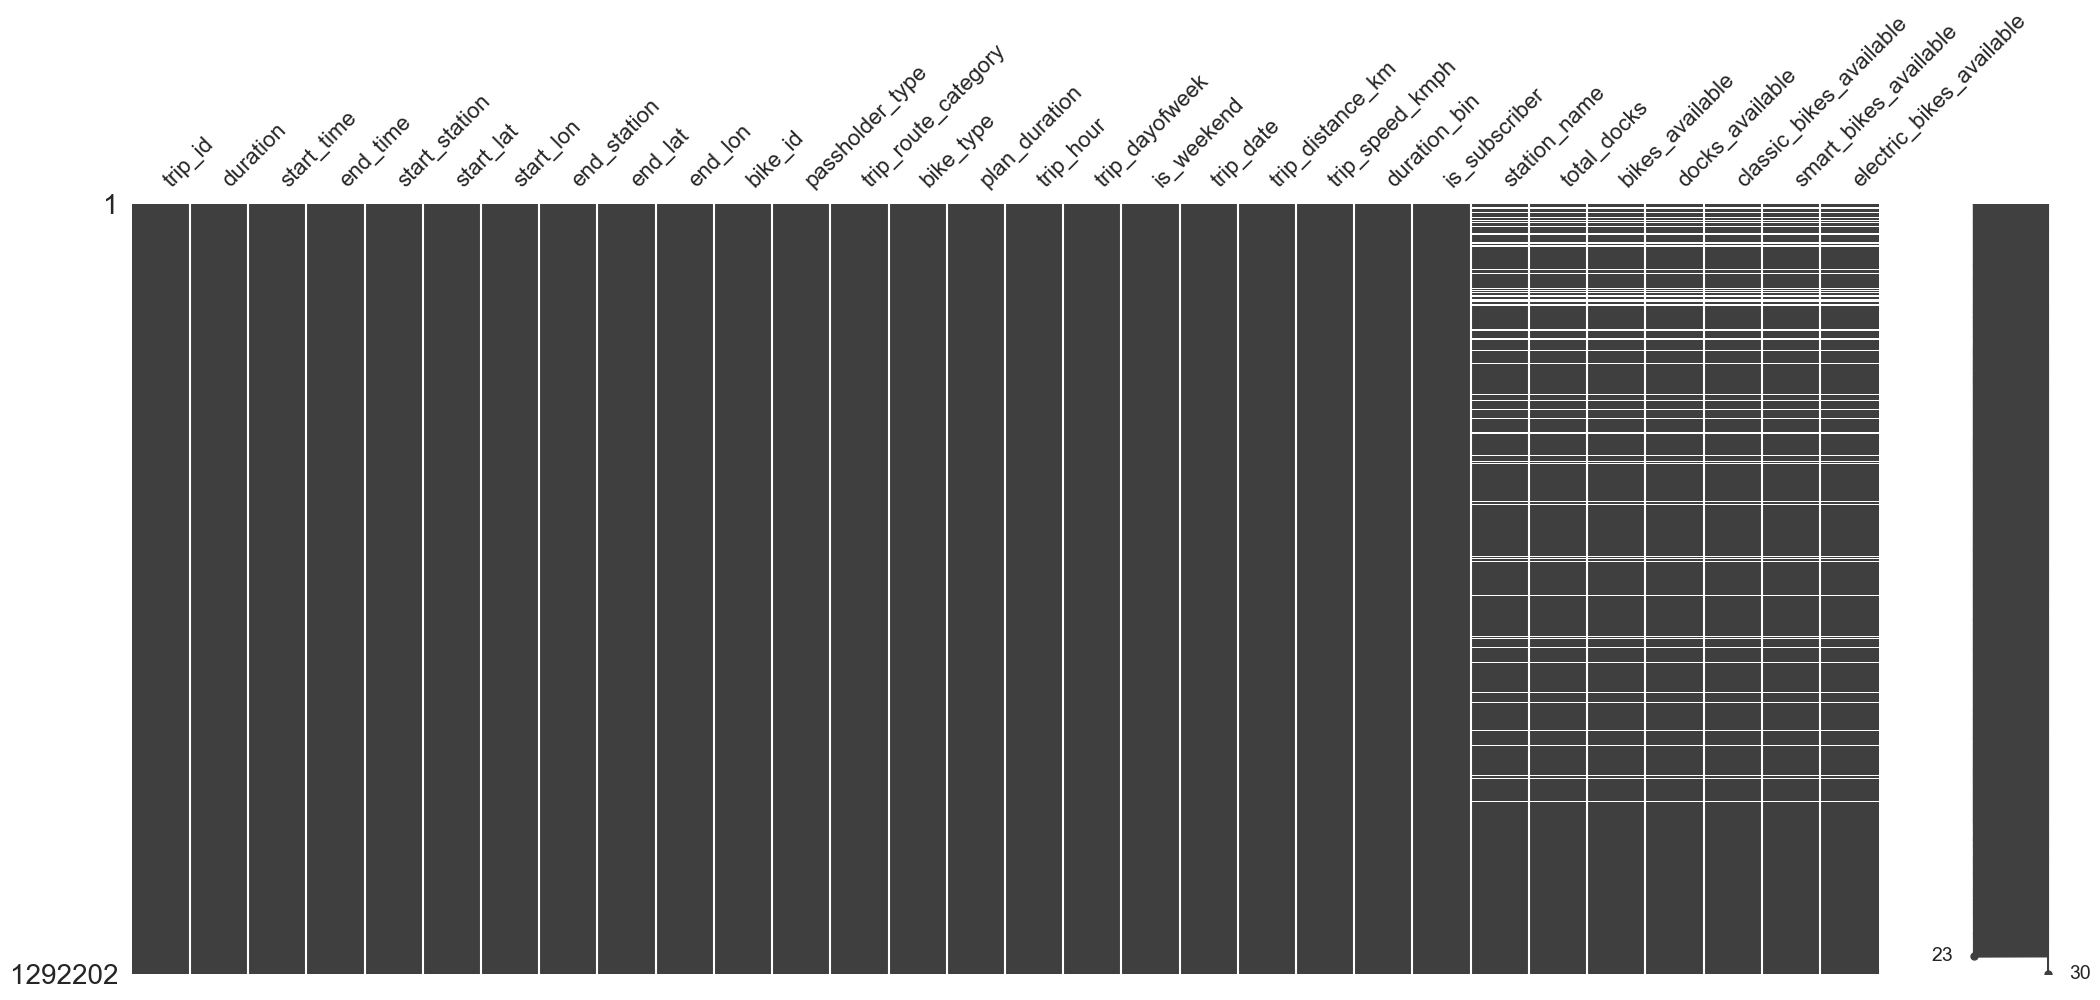

In [17]:
# Visualize missing value patterns
msno.matrix(df)
plt.show()

#### We have missing values in the merged dataset. The data was clean but we introduced missing values when merging the two datasets. Now we will need to handle them here.

In [18]:
# Summary statistics
df.describe()

,trip_id,duration,start_time,end_time,start_station,start_lat,start_lon,end_station,end_lat,end_lon,plan_duration,trip_hour,trip_dayofweek,trip_date,trip_distance_km,trip_speed_kmph,total_docks,bikes_available,docks_available,classic_bikes_available,smart_bikes_available,electric_bikes_available
count,1292202.00,1292202.00,1292202,1292202,1292202.00,1292202.00,1292202.00,1292202.00,1292202.00,1292202.00,1292202.00,1292202.00,1292202.00,1292202,1292202.00,1292202.00,1211749.00,1211749.00,1211749.00,1211749.00,1211749.00,1211749.00
mean,255448864.12,16.38,2022-07-05 11:07:55.165090560,2022-07-05 11:24:17.583753472,3806.83,34.04,-118.32,3793.13,34.04,-118.32,22.62,14.35,3.01,2022-07-04 20:17:36.562983,1.50,7.61,18.89,8.46,10.32,8.06,0.00,0.40
min,17059125.00,1.00,2017-01-01 00:15:00,2017-01-01 00:23:00,3000.00,33.98,-118.50,3000.00,33.98,-118.50,0.00,0.00,0.00,2017-01-01 00:00:00,0.00,0.00,6.00,0.00,0.00,0.00,0.00,0.00
25%,156279581.50,7.00,2021-03-27 18:11:45,2021-03-27 18:28:45,3040.00,34.03,-118.41,3036.00,34.03,-118.41,1.00,11.00,1.00,2021-03-27 00:00:00,0.47,2.37,15.00,5.00,7.00,5.00,0.00,0.00
50%,240076626.50,13.00,2023-02-12 21:54:30,2023-02-12 22:07:00,4212.00,34.05,-118.27,4214.00,34.05,-118.27,30.00,15.00,3.00,2023-02-12 00:00:00,1.01,6.53,18.00,8.00,10.00,7.00,0.00,0.00
75%,357066924.75,23.00,2024-02-17 18:50:30,2024-02-17 19:09:30,4446.00,34.05,-118.25,4444.00,34.05,-118.25,30.00,18.00,5.00,2024-02-17 00:00:00,1.91,9.61,23.00,11.00,13.00,10.00,0.00,1.00
max,475705471.00,59.00,2024-12-31 23:47:00,2025-01-01 00:41:00,4689.00,34.09,-118.20,4689.00,34.09,-118.20,30.00,23.00,6.00,2024-12-31 00:00:00,21.51,1183.77,36.00,22.00,24.00,22.00,0.00,4.00
std,119196762.26,12.39,NaN,NaN,676.05,0.02,0.09,677.93,0.02,0.09,12.65,4.56,1.97,NaN,2.02,24.49,6.64,5.01,4.82,4.87,0.00,0.69


In [19]:
df.describe(include='O')

,bike_id,passholder_type,trip_route_category,bike_type,station_name
count,1292202,1292202,1292202,1292202,1211749
unique,4552,4,2,4,178
top,16600,Monthly Pass,One Way,standard,Downtown Santa Monica E Line Station
freq,3191,960596,1105485,625586,61305


In [20]:
# Count of unique values for categorical variables
print("\nUnique Values for Categorical Variables:")

categorical_columns = df.select_dtypes(include=['object', 'category']).columns
for col in categorical_columns:
    print(f"{col}: {df[col].nunique()} unique values")
    if df[col].nunique() < 10:  # Only show value counts for low-cardinality variables
        print(df[col].value_counts())
        print()


Unique Values for Categorical Variables:
bike_id: 4552 unique values
passholder_type: 4 unique values
passholder_type
Monthly Pass    960596
Walk-up         239488
One Day Pass     88475
Unknown           3643
Name: count, dtype: int64

trip_route_category: 2 unique values
trip_route_category
One Way       1105485
Round Trip     186717
Name: count, dtype: int64

bike_type: 4 unique values
bike_type
standard    625586
electric    566519
Unknown      78149
smart        21948
Name: count, dtype: int64

duration_bin: 4 unique values
duration_bin
5-15m     488891
15-30m    404833
<5m       244043
30-60m    154435
1-2h           0
>2h            0
Name: count, dtype: int64

station_name: 178 unique values


### **Clean the merged dataset**

In [21]:
# Columns to clean
num_cols_with_na = [
    "total_docks",
    "bikes_available",
    "docks_available",
    "classic_bikes_available",
    "smart_bikes_available",
    "electric_bikes_available",
]
cat_cols_with_na = ["station_name"]

# Fill numeric columns with mean
for col in num_cols_with_na:
    if col in df.columns:
        mean_val = df[col].mean()
        df[col].fillna(mean_val, inplace=True)

# Fill categorical columns with mode
for col in cat_cols_with_na:
    if col in df.columns:
        mode_val = df[col].mode().iloc[0]
        df[col].fillna(mode_val, inplace=True)

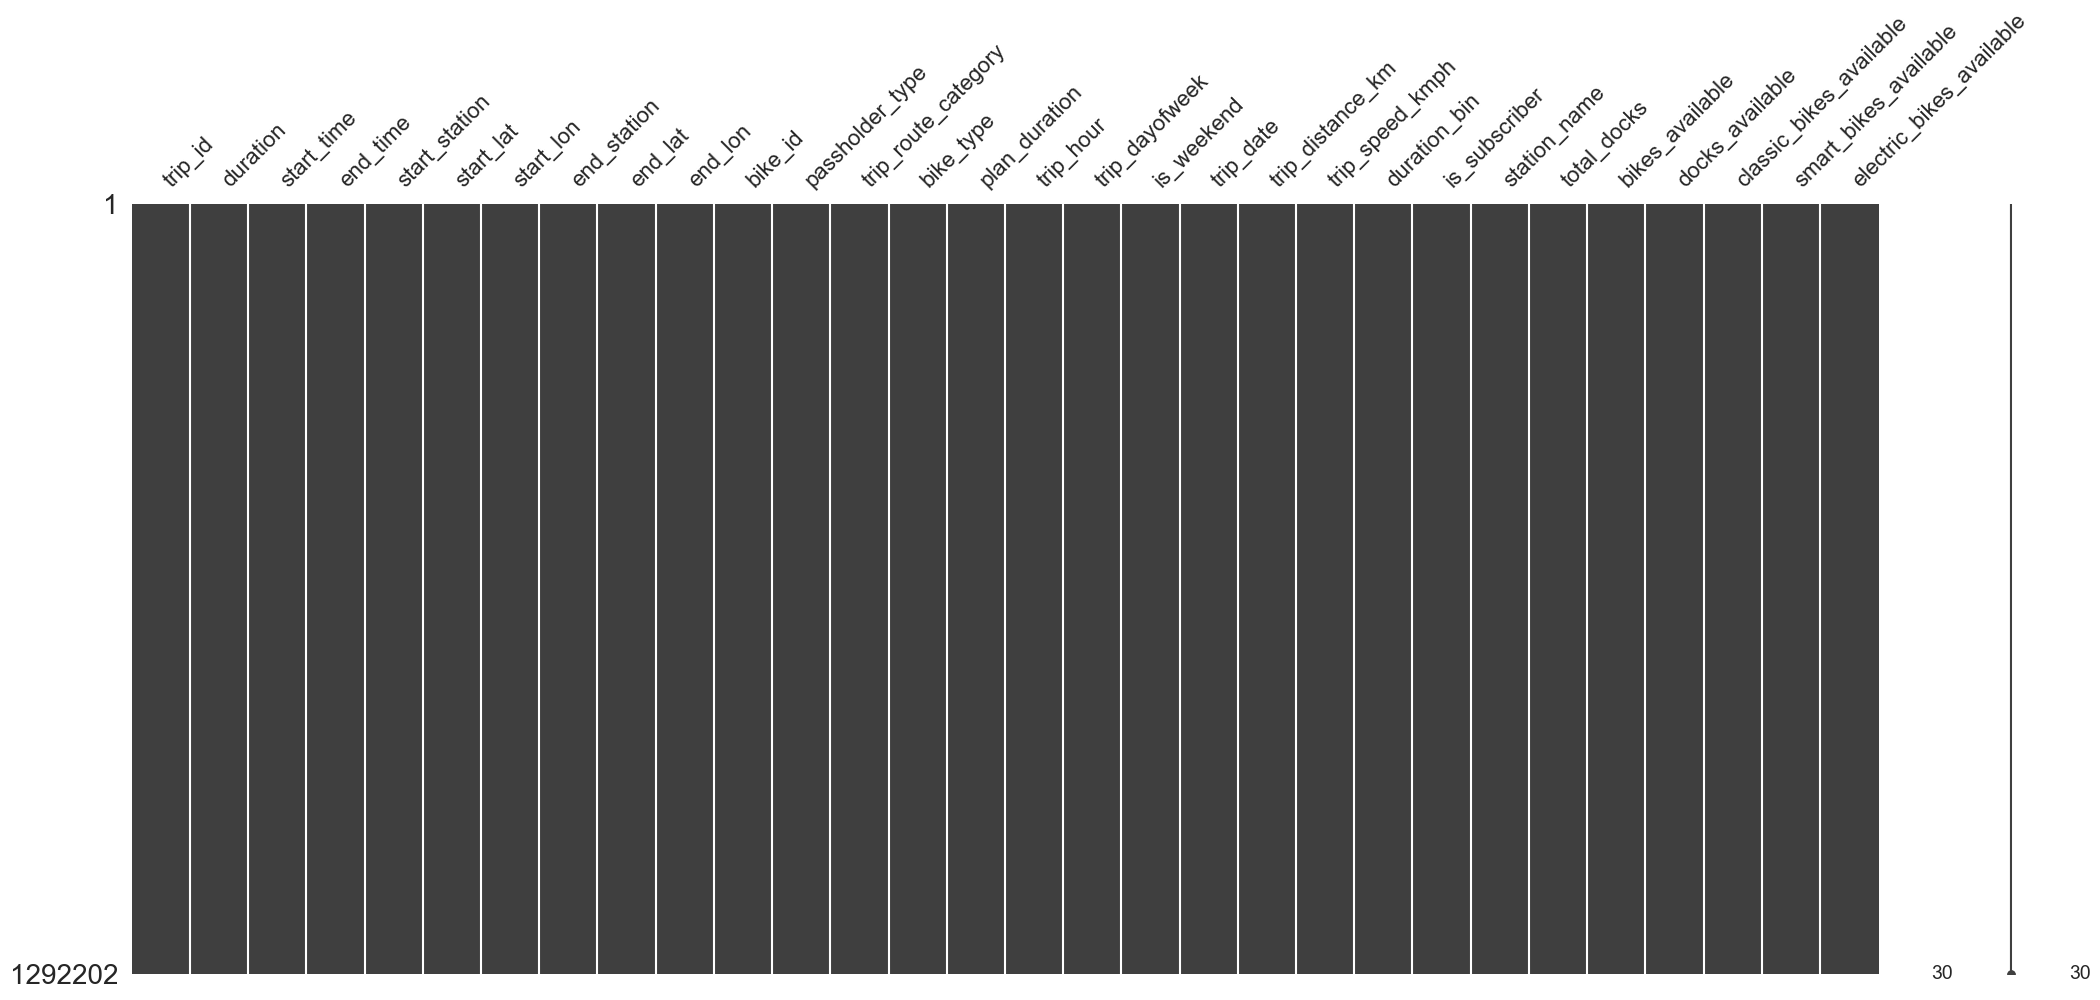

In [22]:
# Visualize missing value patterns
msno.matrix(df)
plt.show()

# **Exploratory Data Analysis**

In [23]:
df.head()

,trip_id,duration,start_time,end_time,start_station,start_lat,start_lon,end_station,end_lat,end_lon,bike_id,passholder_type,trip_route_category,bike_type,plan_duration,trip_hour,trip_dayofweek,is_weekend,trip_date,trip_distance_km,trip_speed_kmph,duration_bin,is_subscriber,station_name,total_docks,bikes_available,docks_available,classic_bikes_available,smart_bikes_available,electric_bikes_available
0,33404951.00,36.00,2017-07-01 00:09:00,2017-07-01 00:45:00,3018.00,34.04,-118.26,3018.00,34.04,-118.26,5996,Walk-up,Round Trip,Unknown,0.00,0,5,True,2017-07-01,0.00,0.00,30-60m,False,Grand & Olympic,19.00,2.00,17.00,2.00,0.00,0.00
1,33404950.00,13.00,2017-07-01 00:10:00,2017-07-01 00:23:00,3055.00,34.04,-118.25,3082.00,34.05,-118.24,5777,Walk-up,One Way,Unknown,0.00,0,5,True,2017-07-01,1.33,6.16,5-15m,False,Downtown Santa Monica E Line Station,18.89,8.46,10.32,8.06,0.00,0.40
2,33404947.00,34.00,2017-07-01 00:11:00,2017-07-01 00:45:00,3018.00,34.04,-118.26,3018.00,34.04,-118.26,6342,Walk-up,Round Trip,Unknown,0.00,0,5,True,2017-07-01,0.00,0.00,30-60m,False,Grand & Olympic,19.00,2.00,17.00,2.00,0.00,0.00
3,33404948.00,34.00,2017-07-01 00:11:00,2017-07-01 00:45:00,3018.00,34.04,-118.26,3018.00,34.04,-118.26,6478,Walk-up,Round Trip,Unknown,0.00,0,5,True,2017-07-01,0.00,0.00,30-60m,False,Grand & Olympic,19.00,2.00,17.00,2.00,0.00,0.00
4,33404949.00,12.00,2017-07-01 00:11:00,2017-07-01 00:23:00,3055.00,34.04,-118.25,3082.00,34.05,-118.24,6411,Walk-up,One Way,Unknown,0.00,0,5,True,2017-07-01,1.33,6.67,5-15m,False,Downtown Santa Monica E Line Station,18.89,8.46,10.32,8.06,0.00,0.40


In [24]:
# create these columns
# 1. trip_duration: duration of the trip in minutes
df['trip_hour'] = df['start_time'].dt.hour
df['weekday']   = df['start_time'].dt.day_name()
df['season']    = pd.cut(
    df['start_time'].dt.month,
    bins=[0,3,6,9,12],
    labels=['Winter','Spring','Summer','Autumn']
)

# 1. Daily & Seasonal Utilization

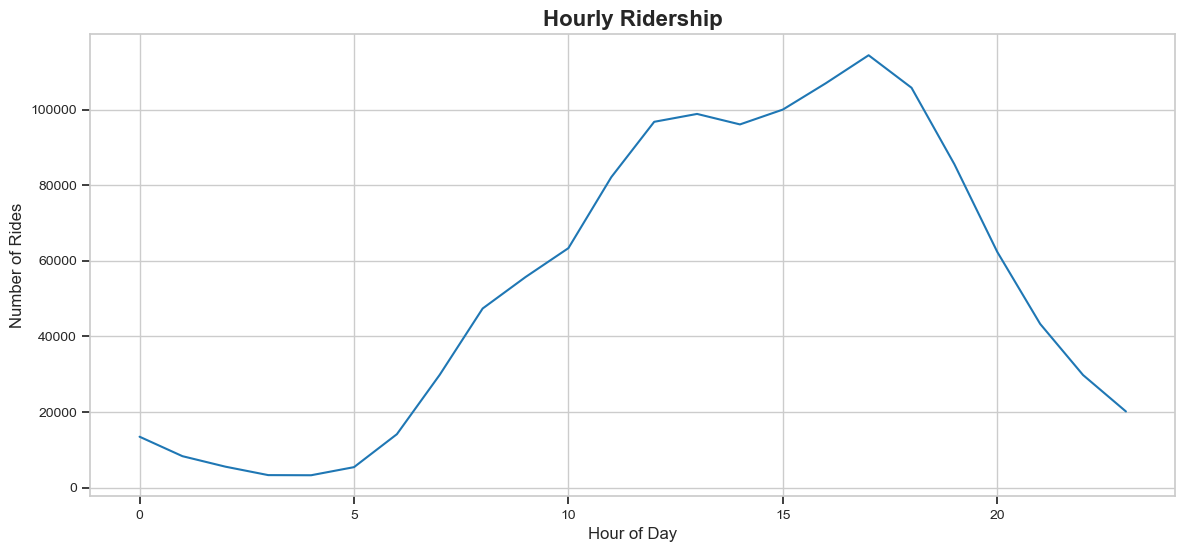

In [25]:
# 1a) Rides by hour
plt.figure(figsize=(14,6))
sns.lineplot(
    data=df.groupby('trip_hour').size().reset_index(name='rides'),
    x='trip_hour', y='rides', palette='viridis'
)
plt.title('Hourly Ridership')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Rides')
plt.show()

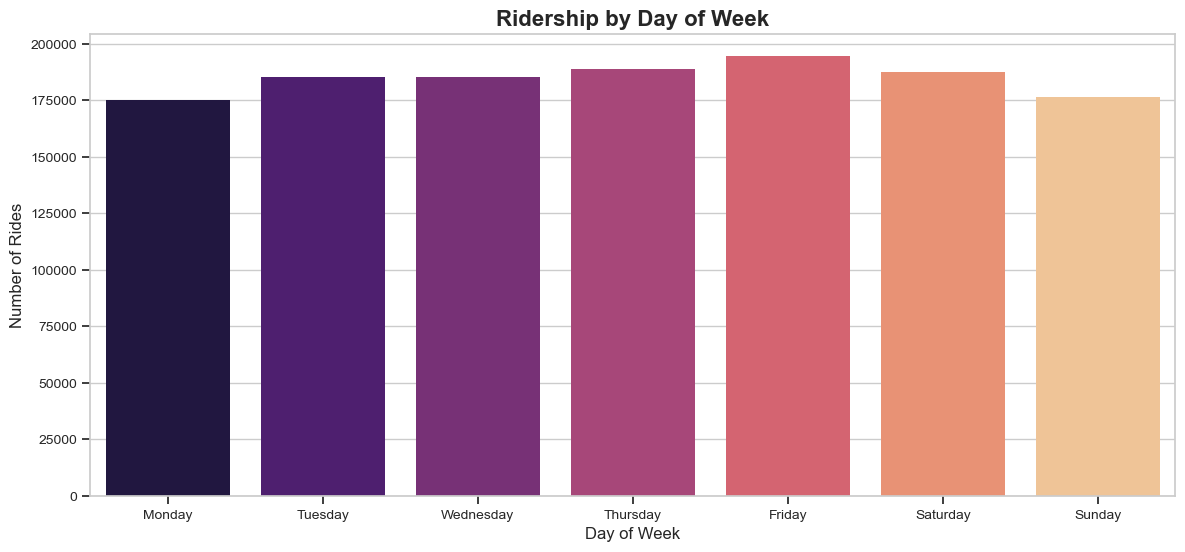

In [26]:
# 1b) Rides by weekday
weekday_order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
daily = df['weekday'].value_counts().reindex(weekday_order).reset_index()
daily.columns = ['weekday','rides']

plt.figure(figsize=(14,6))
sns.barplot(
    data=daily, x='weekday', y='rides', palette='magma'
)
plt.title('Ridership by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Number of Rides')
plt.show()

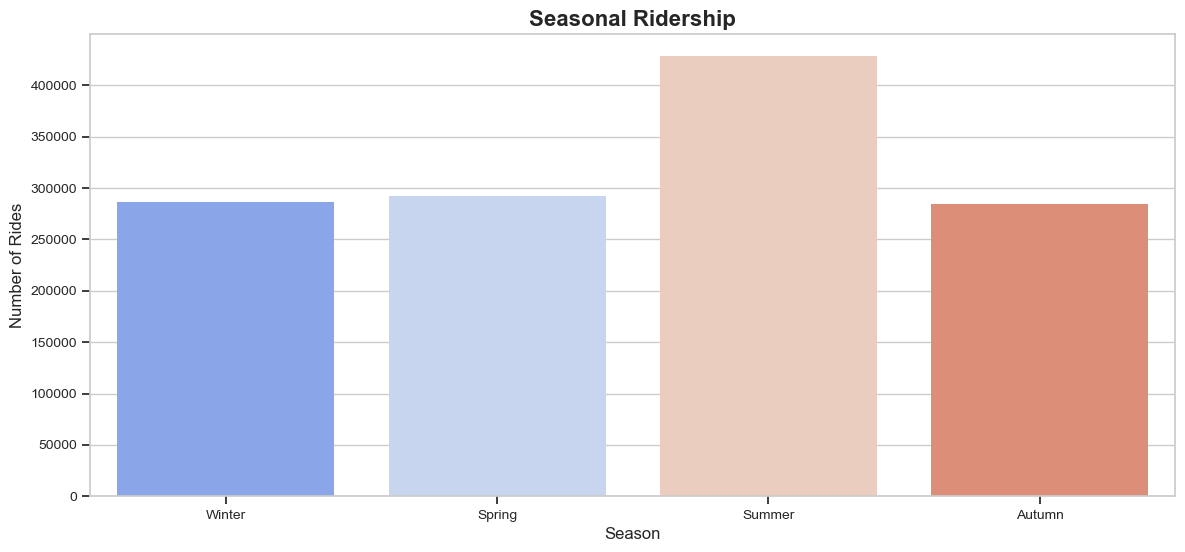

In [27]:
# 1c) Rides by season
season_order = ['Winter','Spring','Summer','Autumn']
seasonal = df['season'].value_counts().reindex(season_order).reset_index()
seasonal.columns = ['season','rides']

plt.figure(figsize=(14,6))
sns.barplot(
    data=seasonal, x='season', y='rides', palette='coolwarm'
)
plt.title('Seasonal Ridership')
plt.xlabel('Season')
plt.ylabel('Number of Rides')
plt.show()

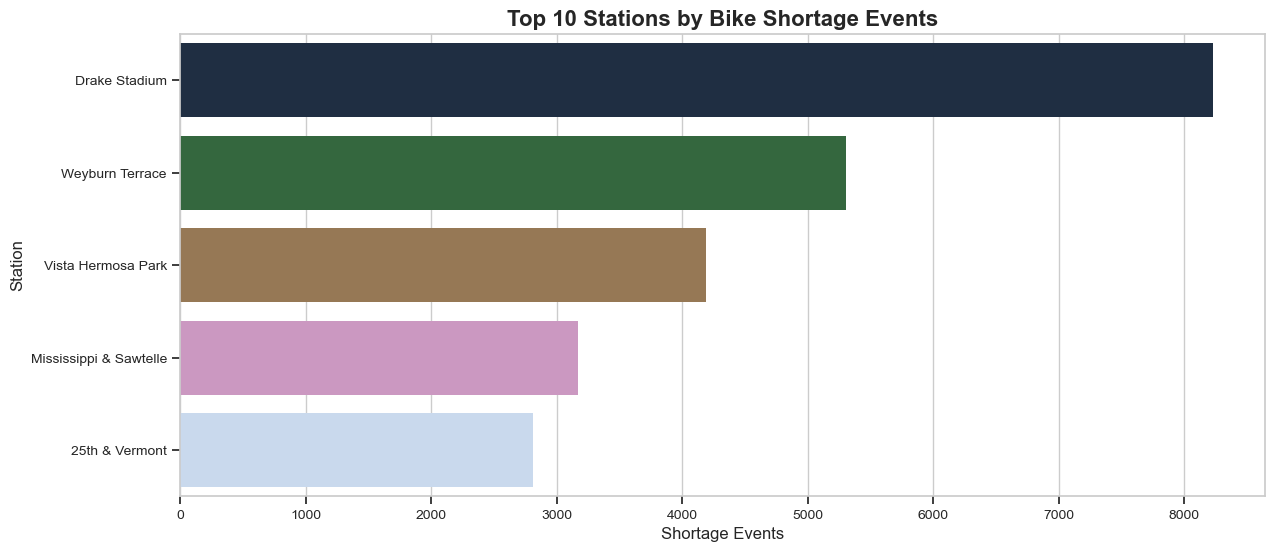

In [28]:
# 2. Station Imbalance & Rebalancing Needs
# Define a “shortage event” when starting station has 0 bikes available
shortages = df[df['bikes_available'] == 0]
station_short = (
    shortages['station_name']
      .value_counts()
      .head(10)
      .reset_index(name='shortage_events')
)
station_short.columns = ['station_name','shortage_events']

plt.figure(figsize=(14,6))
sns.barplot(
    data=station_short,
    x='shortage_events', y='station_name',
    palette='cubehelix'
)
plt.title('Top 10 Stations by Bike Shortage Events')
plt.xlabel('Shortage Events')
plt.ylabel('Station')
plt.show()

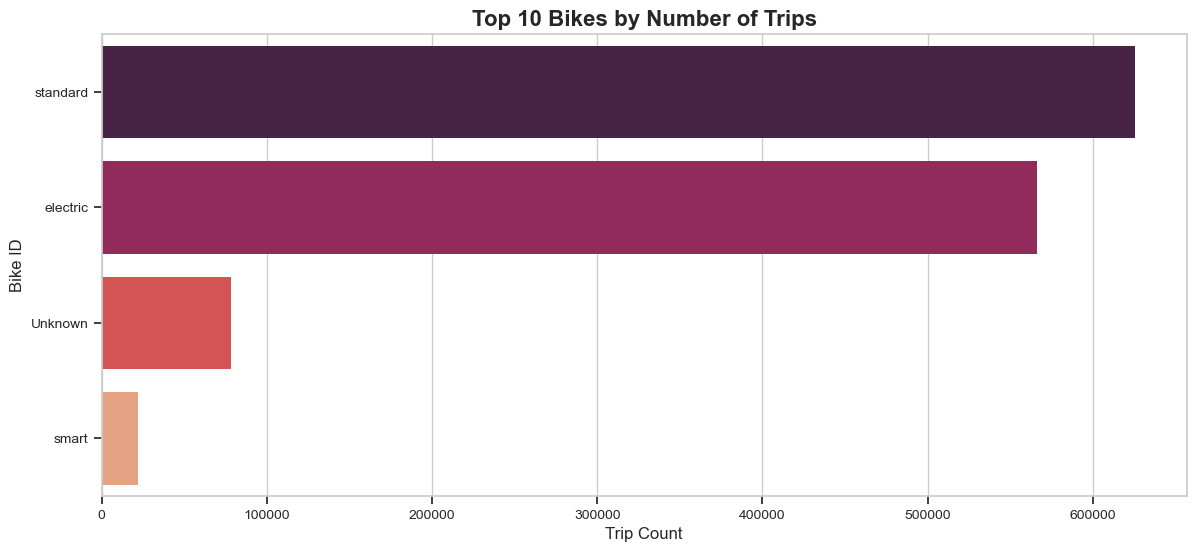

In [29]:
# 3. High‑Demand Bikes & Maintenance Planning
# 3a) Top 10 bikes by trip count
top_bikes_count = (
    df['bike_type']
      .value_counts()
      .head(10)
      .reset_index(name='trip_count')
)
top_bikes_count.columns = ['bike_type','trip_count']

plt.figure(figsize=(14,6))
sns.barplot(
    data=top_bikes_count,
    x='trip_count', y='bike_type',
    palette='rocket'
)
plt.title('Top 10 Bikes by Number of Trips')
plt.xlabel('Trip Count')
plt.ylabel('Bike ID')
plt.show()

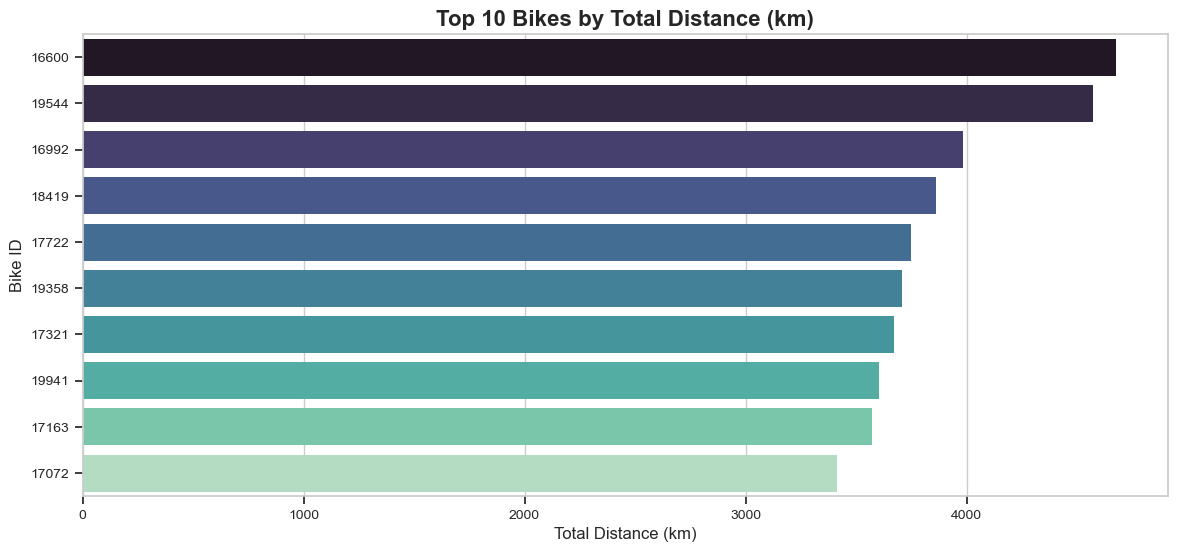

In [30]:
# 3b) Top 10 bikes by total distance
top_bikes_dist = (
    df.groupby('bike_id')['trip_distance_km']
      .sum()
      .sort_values(ascending=False)
      .head(10)
      .reset_index(name='total_km')
)

plt.figure(figsize=(14,6))
sns.barplot(
    data=top_bikes_dist,
    x='total_km', y='bike_id',
    palette='mako'
)
plt.title('Top 10 Bikes by Total Distance (km)')
plt.xlabel('Total Distance (km)')
plt.ylabel('Bike ID')
plt.show()

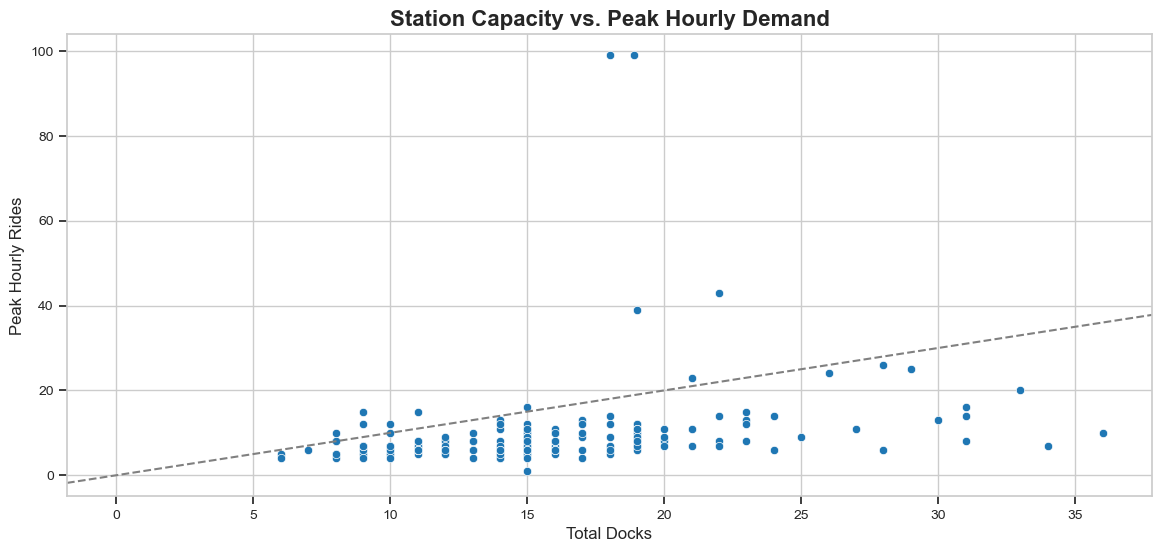

In [31]:
# 4. Capacity Planning
# Compute each station’s peak hourly rides
hourly_station = (
    df.set_index('start_time')
      .groupby('station_name')
      .resample('H')['trip_id']
      .count()
      .reset_index(name='rides')
)
peak_usage = (
    hourly_station.groupby('station_name')['rides']
                  .max()
                  .reset_index()
)

# Merge with capacity
cap_df = peak_usage.merge(
    df[['station_name','total_docks']].drop_duplicates(),
    on='station_name', how='left'
)

plt.figure(figsize=(14,6))
sns.scatterplot(
    data=cap_df, x='total_docks', y='rides',
    palette='flare'
)
plt.title('Station Capacity vs. Peak Hourly Demand')
plt.xlabel('Total Docks')
plt.ylabel('Peak Hourly Rides')
plt.axline((0,0), slope=1, color='gray', linestyle='--')
plt.show()


User Experience & Engagement

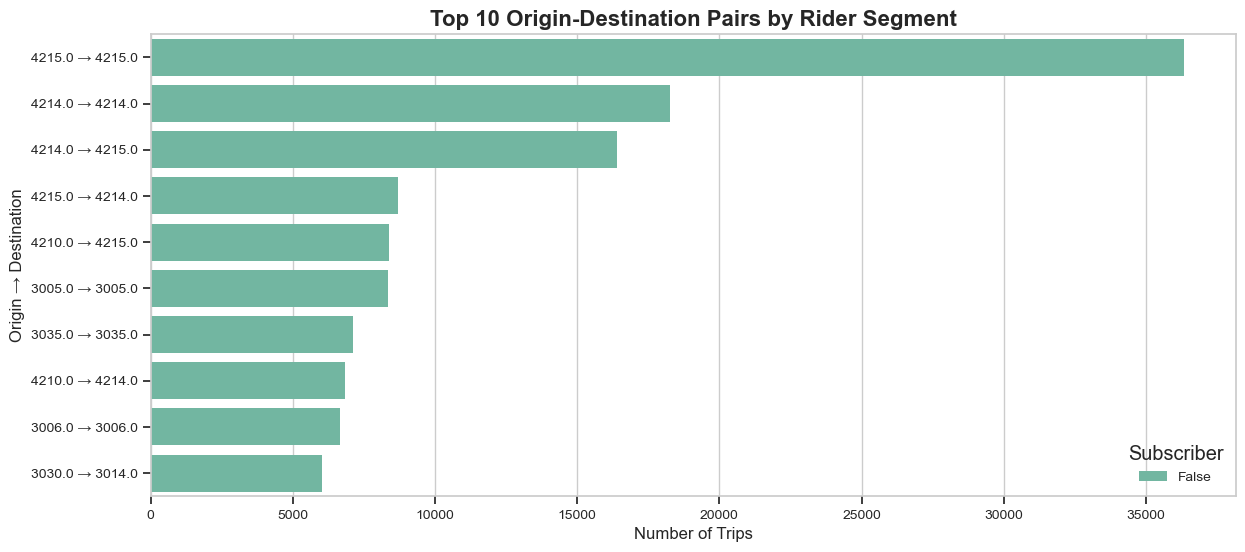

In [32]:
# 1. Trip Patterns & Rider Segments
# Create origin-destination pair
df['od_pair'] = df['start_station'].astype(str) + " → " + df['end_station'].astype(str)

# Count top 10 OD pairs for subscribers vs casual
top_pairs = (
    df.groupby(['is_subscriber', 'od_pair'])
      .size()
      .reset_index(name='count')
      .sort_values(['is_subscriber', 'count'], ascending=[True, False])
      .groupby('is_subscriber')
      .head(10)
)

plt.figure(figsize=(14, 6))
sns.barplot(
    data=top_pairs,
    x='count', y='od_pair',
    hue='is_subscriber',
    palette='Set2'
)
plt.title('Top 10 Origin-Destination Pairs by Rider Segment')
plt.xlabel('Number of Trips')
plt.ylabel('Origin → Destination')
plt.legend(title='Subscriber')
plt.show()

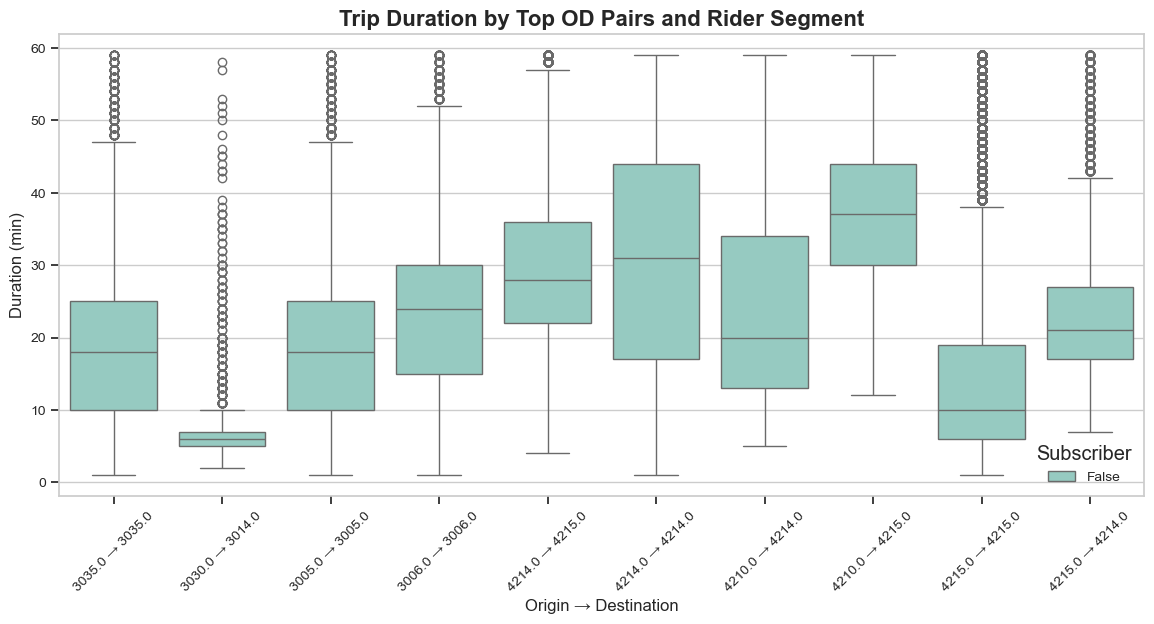

In [33]:
# Distribution of durations for top pairs
top_od = top_pairs['od_pair'].unique()
subset = df[df['od_pair'].isin(top_od)]

plt.figure(figsize=(14, 6))
sns.boxplot(
    data=subset,
    x='od_pair', y='duration',
    hue='is_subscriber',
    palette='Set3'
)
plt.title('Trip Duration by Top OD Pairs and Rider Segment')
plt.xlabel('Origin → Destination')
plt.ylabel('Duration (min)')
plt.xticks(rotation=45)
plt.legend(title='Subscriber')
plt.show()

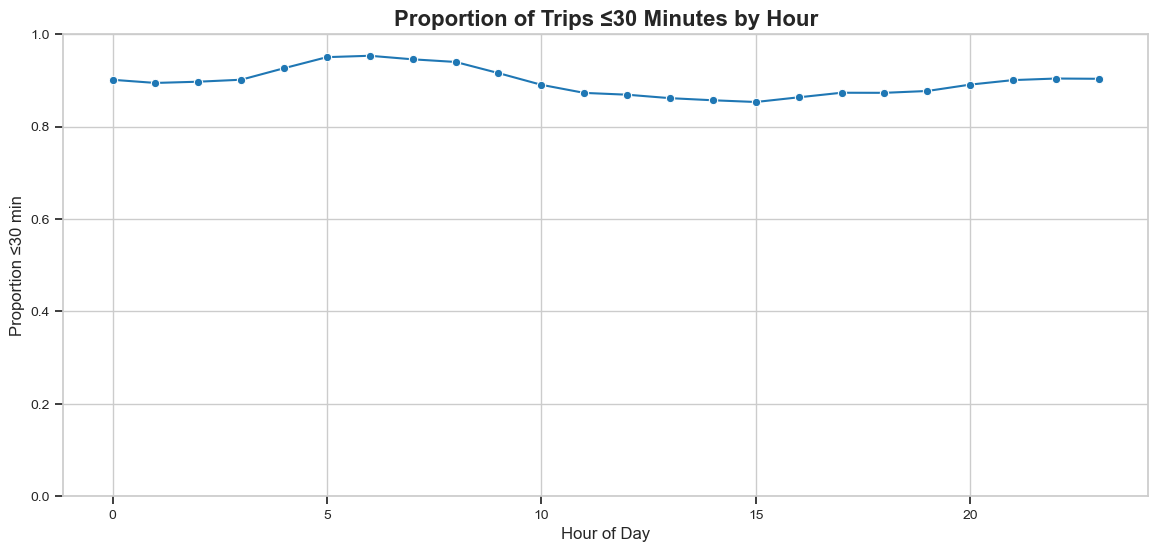

In [34]:
# 2. Peak‑Hour Behavior
# Fraction of trips <=30 min by hour
hour_summary = (
    df.assign(under30=df['duration'] <= 30)
      .groupby('trip_hour')['under30']
      .mean()
      .reset_index(name='pct_under_30')
)

plt.figure(figsize=(14, 6))
sns.lineplot(
    data=hour_summary,
    x='trip_hour', y='pct_under_30',
    marker='o',
    palette='cool'
)
plt.title('Proportion of Trips ≤30 Minutes by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Proportion ≤30 min')
plt.ylim(0, 1)
plt.show()

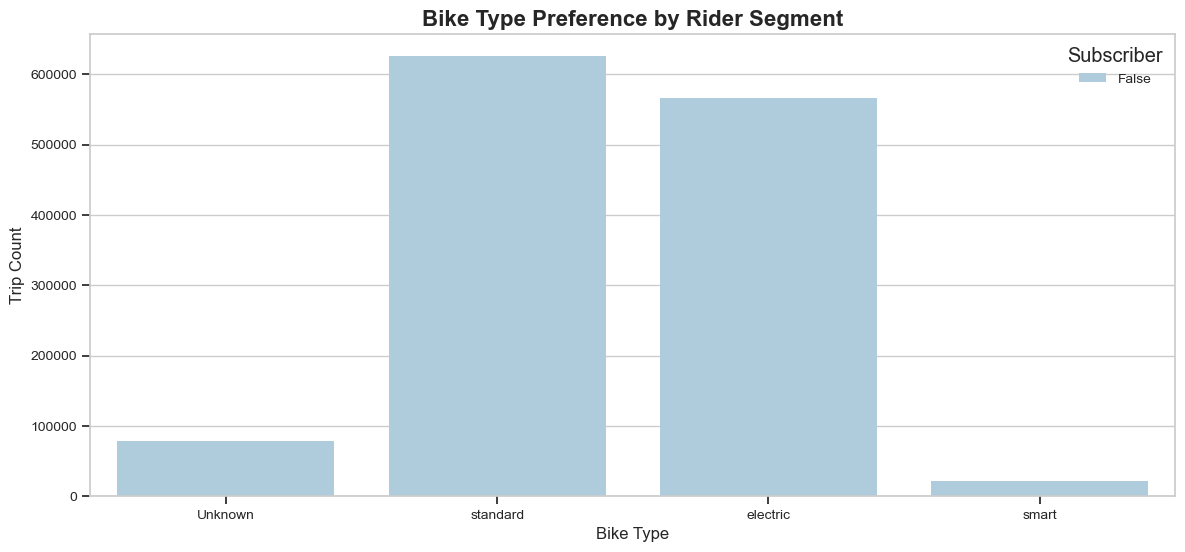

In [35]:
# 3. Bike Type Preference
plt.figure(figsize=(14, 6))
sns.countplot(
    data=df,
    x='bike_type',
    hue='is_subscriber',
    palette='Paired'
)
plt.title('Bike Type Preference by Rider Segment')
plt.xlabel('Bike Type')
plt.ylabel('Trip Count')
plt.legend(title='Subscriber')
plt.show()

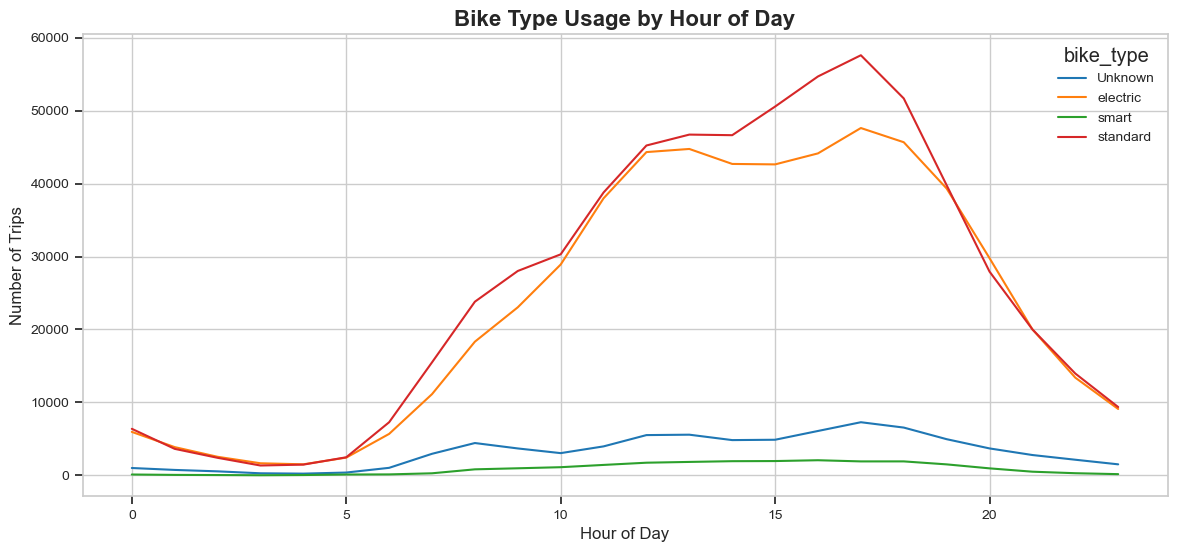

In [36]:
# Variation by time of day (stacked area-like via lineplot)
type_hour = (
    df.groupby(['trip_hour', 'bike_type'])
      .size()
      .reset_index(name='count')
)

plt.figure(figsize=(14, 6))
sns.lineplot(
    data=type_hour,
    x='trip_hour', y='count', hue='bike_type',
    palette='tab10'
)
plt.title('Bike Type Usage by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Trips')
plt.show()

In [37]:
# # 4. First‑Time to Repeat Conversion
# # Requires bike_id; find walk-up users who returned within 30 days
# first_walk = (
#     df[df['passholder_type'] == 'Walk-up']
#       .groupby('bike_id')['start_time']
#       .min()
#       .reset_index(name='first_trip')
# )

# # Any trip by same user within 30d after first
# merged = df.merge(first_walk, on='bike_id')
# merged['days_since_first'] = (merged['start_time'] - merged['first_trip']).dt.days
# converted = merged[
#     (merged['passholder_type'] != 'Walk-up') &
#     (merged['days_since_first'] <= 30)
# ]['bike_id'].unique()

# total_walkers = first_walk['bike_id'].nunique()
# num_converted = len(converted)
# pct_converted = num_converted / total_walkers

# # Display as a single-value bar
# plt.figure(figsize=(14, 6))
# sns.barplot(
#     x=['Converted','Remaining'],
#     y=[pct_converted, 1-pct_converted],
#     palette='Blues'
# )
# plt.title('Walk-Up Riders Converting to Subscriber within 30 Days')
# plt.ylabel('Proportion of Walk-Up Riders')
# plt.ylim(0,1)
# plt.show()

### **Revenue Optimization & Pricing Strategy**

Merge Pricing Info and Compute

In [38]:
pricing_fixed = pd.DataFrame([
    {"passholder_type": "Walk-up",        "plan": "1-Ride",            "start_fee": 0,    "included_minutes": 0,  "overage_rate": 1.75},
    {"passholder_type": "One Day Pass",   "plan": "24-Hour Access",    "start_fee": 5,    "included_minutes": 30, "overage_rate": 1.75},
    {"passholder_type": "Monthly Pass",   "plan": "30-Day Pass",       "start_fee": 17,   "included_minutes": 30, "overage_rate": 1.75},
    {"passholder_type": "Unknown",        "plan": "1-Ride",            "start_fee": 0,    "included_minutes": 0,  "overage_rate": 1.75},
])

In [39]:
pricing_fixed

,passholder_type,plan,start_fee,included_minutes,overage_rate
0,Walk-up,1-Ride,0,0,1.75
1,One Day Pass,24-Hour Access,5,30,1.75
2,Monthly Pass,30-Day Pass,17,30,1.75
3,Unknown,1-Ride,0,0,1.75


In [40]:
df_pricing = df.merge(pricing_fixed, on='passholder_type', how='left')

# Calculate overage
df_pricing['overage_minutes'] = (df_pricing['duration'] - df_pricing['included_minutes']).clip(lower=0)

# Calculate cost: only overage is charged (assumes start_fee is subscription fee, not per-trip)
df_pricing['trip_cost'] = df_pricing['overage_minutes'] * df_pricing['overage_rate']
df_pricing.head()

,trip_id,duration,start_time,end_time,start_station,start_lat,start_lon,end_station,end_lat,end_lon,bike_id,passholder_type,trip_route_category,bike_type,plan_duration,trip_hour,trip_dayofweek,is_weekend,trip_date,trip_distance_km,trip_speed_kmph,duration_bin,is_subscriber,station_name,total_docks,bikes_available,docks_available,classic_bikes_available,smart_bikes_available,electric_bikes_available,weekday,season,od_pair,plan,start_fee,included_minutes,overage_rate,overage_minutes,trip_cost
0,33404951.00,36.00,2017-07-01 00:09:00,2017-07-01 00:45:00,3018.00,34.04,-118.26,3018.00,34.04,-118.26,5996,Walk-up,Round Trip,Unknown,0.00,0,5,True,2017-07-01,0.00,0.00,30-60m,False,Grand & Olympic,19.00,2.00,17.00,2.00,0.00,0.00,Saturday,Summer,3018.0 → 3018.0,1-Ride,0,0,1.75,36.00,63.00
1,33404950.00,13.00,2017-07-01 00:10:00,2017-07-01 00:23:00,3055.00,34.04,-118.25,3082.00,34.05,-118.24,5777,Walk-up,One Way,Unknown,0.00,0,5,True,2017-07-01,1.33,6.16,5-15m,False,Downtown Santa Monica E Line Station,18.89,8.46,10.32,8.06,0.00,0.40,Saturday,Summer,3055.0 → 3082.0,1-Ride,0,0,1.75,13.00,22.75
2,33404947.00,34.00,2017-07-01 00:11:00,2017-07-01 00:45:00,3018.00,34.04,-118.26,3018.00,34.04,-118.26,6342,Walk-up,Round Trip,Unknown,0.00,0,5,True,2017-07-01,0.00,0.00,30-60m,False,Grand & Olympic,19.00,2.00,17.00,2.00,0.00,0.00,Saturday,Summer,3018.0 → 3018.0,1-Ride,0,0,1.75,34.00,59.50
3,33404948.00,34.00,2017-07-01 00:11:00,2017-07-01 00:45:00,3018.00,34.04,-118.26,3018.00,34.04,-118.26,6478,Walk-up,Round Trip,Unknown,0.00,0,5,True,2017-07-01,0.00,0.00,30-60m,False,Grand & Olympic,19.00,2.00,17.00,2.00,0.00,0.00,Saturday,Summer,3018.0 → 3018.0,1-Ride,0,0,1.75,34.00,59.50
4,33404949.00,12.00,2017-07-01 00:11:00,2017-07-01 00:23:00,3055.00,34.04,-118.25,3082.00,34.05,-118.24,6411,Walk-up,One Way,Unknown,0.00,0,5,True,2017-07-01,1.33,6.67,5-15m,False,Downtown Santa Monica E Line Station,18.89,8.46,10.32,8.06,0.00,0.40,Saturday,Summer,3055.0 → 3082.0,1-Ride,0,0,1.75,12.00,21.00


In [69]:
# Create trip duration bins
df_pricing['duration_bin'] = pd.cut(
    df_pricing['duration'], 
    bins=[0, 15, 30, 45, 60, 90, 120, 180, np.inf], 
    labels=['0-15', '15-30', '30-45', '45-60', '60-90', '90-120', '120-180', '180+']
)

In [72]:
# Total and average revenue per plan
plan_revenue = df_pricing.groupby('plan')['trip_cost'].sum().reset_index(name='total_revenue')
plan_rides   = df_pricing.groupby('plan')['trip_id'].count().reset_index(name='ride_count')
plan_perf    = plan_revenue.merge(plan_rides, on='plan')
plan_perf['avg_rev_per_ride'] = plan_perf['total_revenue'] / plan_perf['ride_count']
plan_perf

,plan,total_revenue,ride_count,avg_rev_per_ride
0,1-Ride,9876448.75,243131,40.62
1,24-Hour Access,463699.25,88475,5.24
2,30-Day Pass,1168252.75,960596,1.22


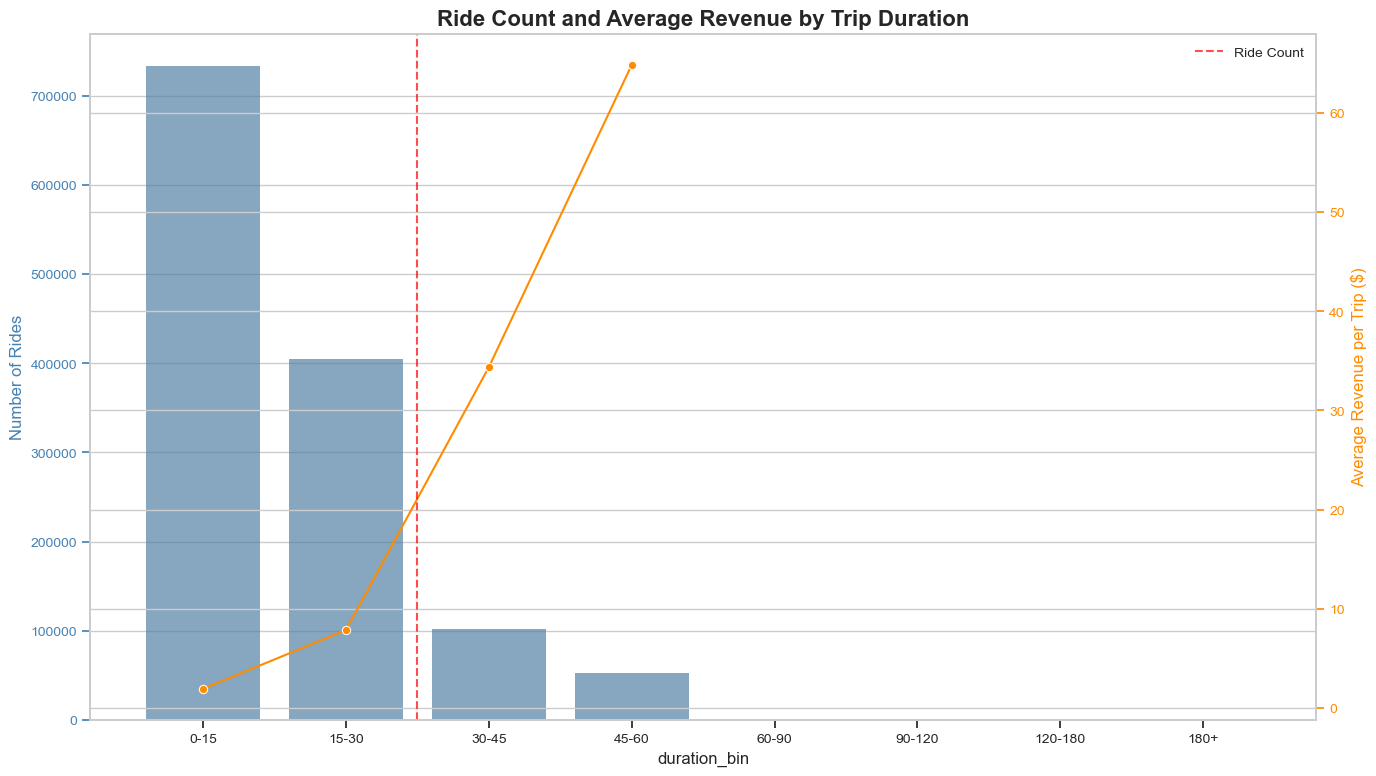

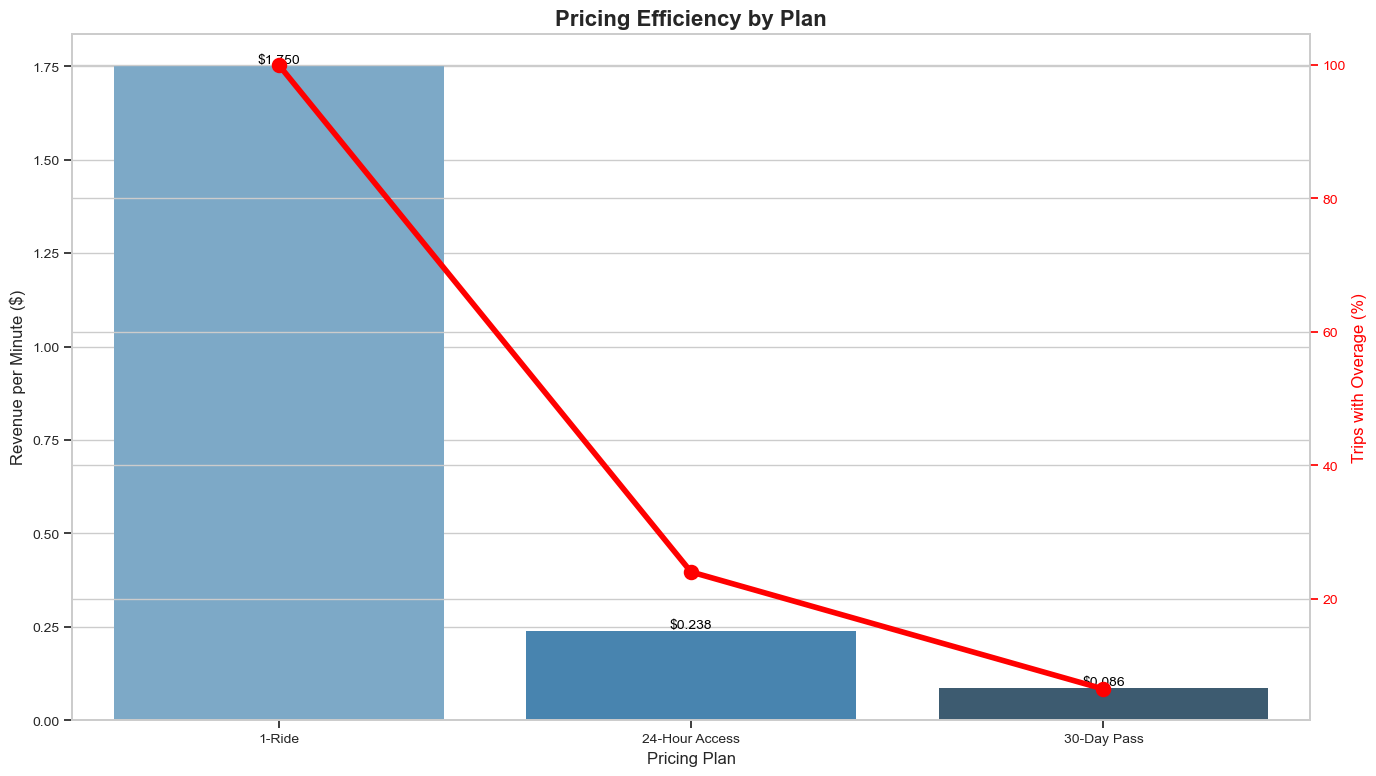

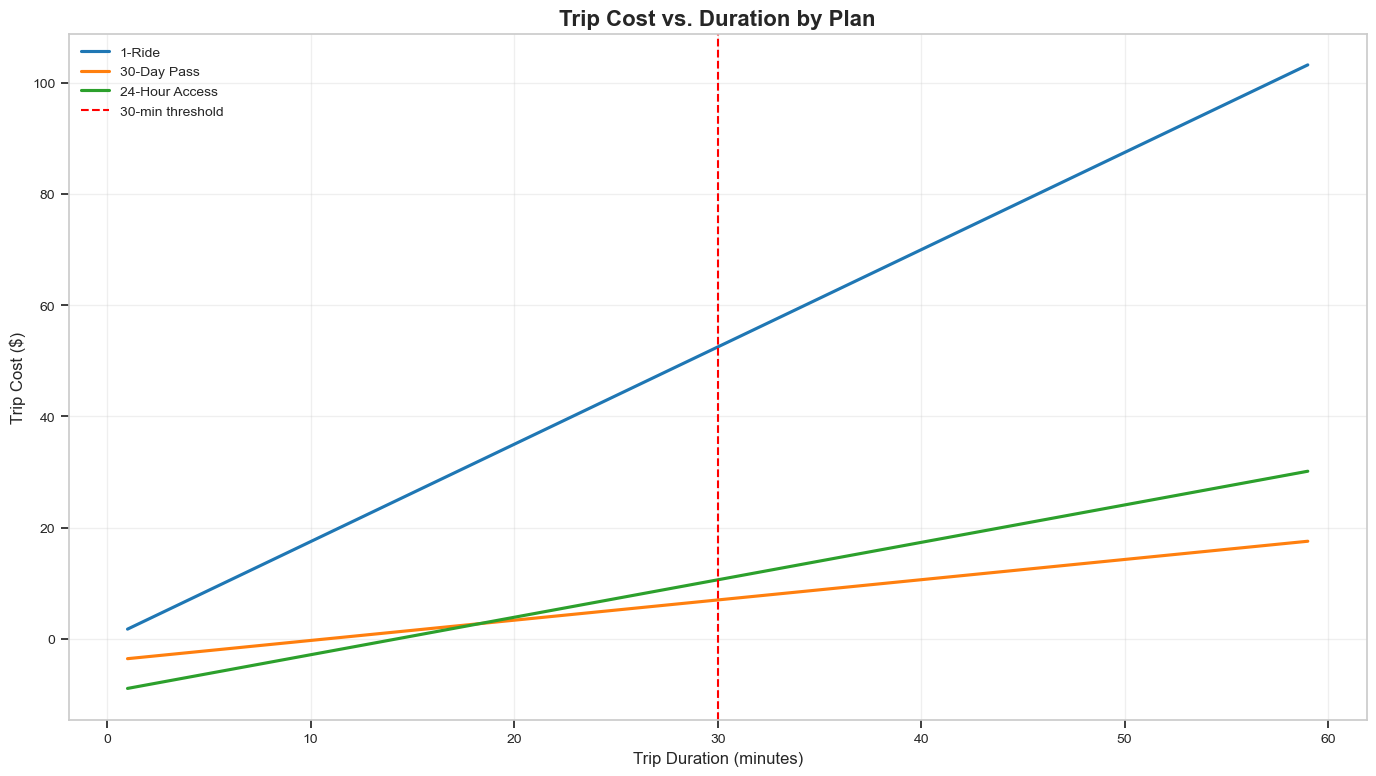

In [78]:
# Improved Pricing Analysis with Duration Bins

# Create duration bins
df_pricing['duration_bin'] = pd.cut(
    df_pricing['duration'], 
    bins=[0, 15, 30, 45, 60, 90, 120, 180, np.inf], 
    labels=['0-15', '15-30', '30-45', '45-60', '60-90', '90-120', '120-180', '180+']
)

# Analyze revenue by duration bin
trip_duration_bins = df_pricing.groupby('duration_bin').agg(
    ride_count=('trip_id', 'count'),
    avg_trip_cost=('trip_cost', 'mean'),
    total_revenue=('trip_cost', 'sum')
).reset_index()

# Calculate percentage of rides and revenue
trip_duration_bins['pct_rides'] = trip_duration_bins['ride_count'] / trip_duration_bins['ride_count'].sum() * 100
trip_duration_bins['pct_revenue'] = trip_duration_bins['total_revenue'] / trip_duration_bins['total_revenue'].sum() * 100

# Create a visualization that shows the pattern
plt.figure(figsize=(14, 8))

# Plot the ride count bars
ax1 = plt.subplot(111)
sns.barplot(
    data=trip_duration_bins, 
    x='duration_bin', 
    y='ride_count', 
    color='steelblue',
    alpha=0.7,
    ax=ax1
)
ax1.set_ylabel('Number of Rides', color='steelblue')
ax1.tick_params(axis='y', colors='steelblue')

# Create a second y-axis for revenue
ax2 = ax1.twinx()
sns.lineplot(
    data=trip_duration_bins, 
    x='duration_bin', 
    y='avg_trip_cost', 
    marker='o', 
    color='darkorange',
    ax=ax2
)
ax2.set_ylabel('Average Revenue per Trip ($)', color='darkorange')
ax2.tick_params(axis='y', colors='darkorange')

# Add vertical line at 30 minute mark (included minutes threshold)
plt.axvline(x=1.5, color='red', linestyle='--', alpha=0.7, label='30-min threshold')

plt.title('Ride Count and Average Revenue by Trip Duration', fontsize=16)
plt.xlabel('Trip Duration (minutes)')
plt.xticks(rotation=45)

# Add a legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, ['Ride Count'] + labels2, loc='upper right')

plt.tight_layout()
plt.show()

# Analyze pricing efficiency by plan
plan_efficiency = df_pricing.groupby('plan').agg(
    total_trips=('trip_id', 'count'),
    trips_with_overage=('overage_flag', 'sum'),
    avg_trip_cost=('trip_cost', 'mean'),
    revenue_per_minute=('trip_cost', lambda x: x.sum() / df_pricing.loc[x.index, 'duration'].sum())
).reset_index()

# Calculate overage percentage
plan_efficiency['overage_pct'] = plan_efficiency['trips_with_overage'] / plan_efficiency['total_trips'] * 100

# Plot the pricing efficiency
plt.figure(figsize=(14, 8))

# Create the primary bar chart for revenue per minute
ax1 = plt.subplot(111)
g1 = sns.barplot(
    data=plan_efficiency, 
    x='plan', 
    y='revenue_per_minute', 
    palette='Blues_d',
    ax=ax1
)
ax1.set_ylabel('Revenue per Minute ($)')
ax1.set_xlabel('Pricing Plan')
ax1.set_title('Pricing Efficiency by Plan', fontsize=16)

# Add text labels to the bars
for i, p in enumerate(g1.patches):
    ax1.annotate(
        f'${p.get_height():.3f}',
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center', 
        va='bottom',
        fontsize=10,
        color='black'
    )

# Create a second y-axis for overage percentage
ax2 = ax1.twinx()
g2 = sns.pointplot(
    data=plan_efficiency, 
    x='plan', 
    y='overage_pct', 
    color='red',
    scale=1.5,
    ax=ax2
)
ax2.set_ylabel('Trips with Overage (%)', color='red')
ax2.tick_params(axis='y', colors='red')

plt.tight_layout()
plt.show()

# Price sensitivity analysis by plan
# For each plan, how does duration relate to the amount of revenue?

# Get unique plans
plans = df_pricing['plan'].unique()

plt.figure(figsize=(14, 8))

for plan in plans:
    plan_data = df_pricing[df_pricing['plan'] == plan]
    # Create a simple duration -> revenue scatter with trend line
    sns.regplot(
        x='duration',
        y='trip_cost',
        data=plan_data,
        scatter=False,
        label=plan
    )

plt.axvline(x=30, color='red', linestyle='--', label='30-min threshold')
plt.title('Trip Cost vs. Duration by Plan', fontsize=16)
plt.xlabel('Trip Duration (minutes)')
plt.ylabel('Trip Cost ($)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### **Network Growth & Expansion Planning**

In [48]:
# # 1) Geographic Demand Gaps
# # — heatmap of trip origins, overlay station locations
# plt.figure(figsize=(14,6))
# sns.kdeplot(
#     data=df, x='start_lon', y='start_lat',
#     cmap='viridis', fill=True, thresh=0.05, levels=15
# )
# plt.scatter(
#     stations['station_lon'], stations['station_lat'],
#     c='red', s=20, alpha=0.6, label='Stations'
# )
# plt.title('Trip Origin Density & Station Locations')
# plt.xlabel('Longitude')
# plt.ylabel('Latitude')
# plt.legend()
# plt.show()

In [52]:
df.head(6)

,trip_id,duration,start_time,end_time,start_station,start_lat,start_lon,end_station,end_lat,end_lon,bike_id,passholder_type,trip_route_category,bike_type,plan_duration,trip_hour,trip_dayofweek,is_weekend,trip_date,trip_distance_km,trip_speed_kmph,duration_bin,is_subscriber,station_name,total_docks,bikes_available,docks_available,classic_bikes_available,smart_bikes_available,electric_bikes_available,weekday,season,od_pair
0,33404951.00,36.00,2017-07-01 00:09:00,2017-07-01 00:45:00,3018.00,34.04,-118.26,3018.00,34.04,-118.26,5996,Walk-up,Round Trip,Unknown,0.00,0,5,True,2017-07-01,0.00,0.00,30-60m,False,Grand & Olympic,19.00,2.00,17.00,2.00,0.00,0.00,Saturday,Summer,3018.0 → 3018.0
1,33404950.00,13.00,2017-07-01 00:10:00,2017-07-01 00:23:00,3055.00,34.04,-118.25,3082.00,34.05,-118.24,5777,Walk-up,One Way,Unknown,0.00,0,5,True,2017-07-01,1.33,6.16,5-15m,False,Downtown Santa Monica E Line Station,18.89,8.46,10.32,8.06,0.00,0.40,Saturday,Summer,3055.0 → 3082.0
2,33404947.00,34.00,2017-07-01 00:11:00,2017-07-01 00:45:00,3018.00,34.04,-118.26,3018.00,34.04,-118.26,6342,Walk-up,Round Trip,Unknown,0.00,0,5,True,2017-07-01,0.00,0.00,30-60m,False,Grand & Olympic,19.00,2.00,17.00,2.00,0.00,0.00,Saturday,Summer,3018.0 → 3018.0
3,33404948.00,34.00,2017-07-01 00:11:00,2017-07-01 00:45:00,3018.00,34.04,-118.26,3018.00,34.04,-118.26,6478,Walk-up,Round Trip,Unknown,0.00,0,5,True,2017-07-01,0.00,0.00,30-60m,False,Grand & Olympic,19.00,2.00,17.00,2.00,0.00,0.00,Saturday,Summer,3018.0 → 3018.0
4,33404949.00,12.00,2017-07-01 00:11:00,2017-07-01 00:23:00,3055.00,34.04,-118.25,3082.00,34.05,-118.24,6411,Walk-up,One Way,Unknown,0.00,0,5,True,2017-07-01,1.33,6.67,5-15m,False,Downtown Santa Monica E Line Station,18.89,8.46,10.32,8.06,0.00,0.40,Saturday,Summer,3055.0 → 3082.0
5,33404946.00,18.00,2017-07-01 00:12:00,2017-07-01 00:30:00,3047.00,34.04,-118.27,3005.00,34.05,-118.26,5778,Walk-up,One Way,Unknown,0.00,0,5,True,2017-07-01,1.19,3.97,15-30m,False,Pico & Flower,36.00,16.00,20.00,15.00,0.00,1.00,Saturday,Summer,3047.0 → 3005.0


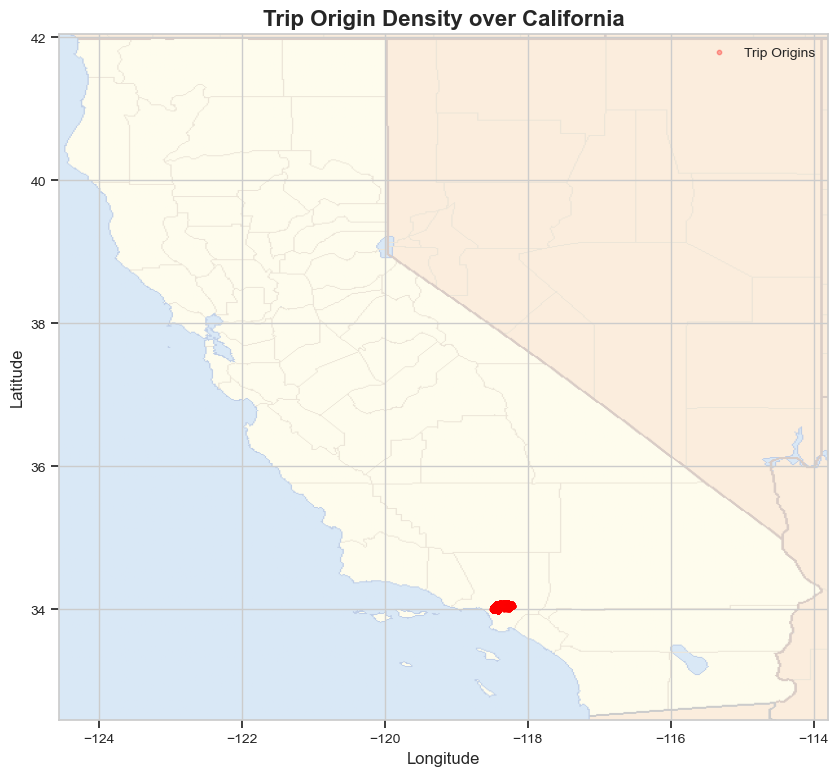

In [ ]:
# Create directory for image
PROJECT_ROOT_DIR = "."  # Change this if needed
images_path = os.path.join(PROJECT_ROOT_DIR, "images", "end_to_end_project")
os.makedirs(images_path, exist_ok=True)

# Download California background map if needed
images_path = os.path.join(PROJECT_ROOT_DIR, "images", "end_to_end_project")
os.makedirs(images_path, exist_ok=True)
filename = "california.png"
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
url = DOWNLOAD_ROOT + "images/end_to_end_project/" + filename
filepath = os.path.join(images_path, filename)

if not os.path.exists(filepath):
    urllib.request.urlretrieve(url, filepath)

# Load map image
california_img = mpimg.imread(filepath)

# Plot KDE + stations over California map
plt.figure(figsize=(14, 8))
sns.kdeplot(
    data=df, x='start_lon', y='start_lat',
    cmap='viridis', fill=True, thresh=0.05, levels=15, alpha=0.6
)
plt.imshow(
    california_img,
    extent=[-124.55, -113.80, 32.45, 42.05],
    alpha=0.4,
    zorder=0
)
plt.scatter(
    df['start_lon'], df['start_lat'],
    c='red', s=10, alpha=0.3, label='Trip Origins'
)
plt.title('Trip Origin Density over California')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [76]:
# # Improved geographical visualization with proper zoom level

# # First, get the bounds of your data
# min_lon = df['start_lon'].min()
# max_lon = df['start_lon'].max()
# min_lat = df['start_lat'].min()
# max_lat = df['start_lat'].max()

# # Add some padding (10%)
# lon_padding = (max_lon - min_lon) * 0.1
# lat_padding = (max_lat - min_lat) * 0.1

# # Create a new focused plot
# plt.figure(figsize=(14, 10))

# # Plot station locations
# plt.scatter(
#     stations['station_lon'], 
#     stations['station_lat'],
#     c='blue', 
#     s=50, 
#     alpha=0.7, 
#     label='Stations'
# )

# # Plot trip density as a heatmap
# sns.kdeplot(
#     data=df,
#     x='start_lon',
#     y='start_lat',
#     cmap='viridis',
#     fill=True,
#     alpha=0.5,
#     levels=15
# )

# # Add most popular routes as lines
# # Get top 10 routes
# route_counts = df.groupby(['start_station', 'end_station']).size().reset_index(name='count')
# top_routes = route_counts.nlargest(10, 'count')

# # For each top route, plot a line
# for _, route in top_routes.iterrows():
#     # Get start coordinates
#     start_coords = stations[stations['station_id'] == route['start_station']][['station_lon', 'station_lat']].values[0]
    
#     # Get end coordinates
#     end_coords = stations[stations['station_id'] == route['end_station']][['station_lon', 'station_lat']].values[0]
    
#     # Plot the line with width proportional to count
#     plt.plot(
#         [start_coords[0], end_coords[0]], 
#         [start_coords[1], end_coords[1]],
#         'r-',
#         alpha=0.6,
#         linewidth=route['count']/route['count'].max() * 5
#     )

# # Set focused bounds with padding
# plt.xlim(min_lon - lon_padding, max_lon + lon_padding)
# plt.ylim(min_lat - lat_padding, max_lat + lat_padding)

# # Add labels and title
# plt.title('Metro Bike Share Network: Stations, Trip Density, and Popular Routes', fontsize=16)
# plt.xlabel('Longitude')
# plt.ylabel('Latitude')
# plt.legend()
# plt.grid(True, alpha=0.3)
# plt.tight_layout()
# plt.show()

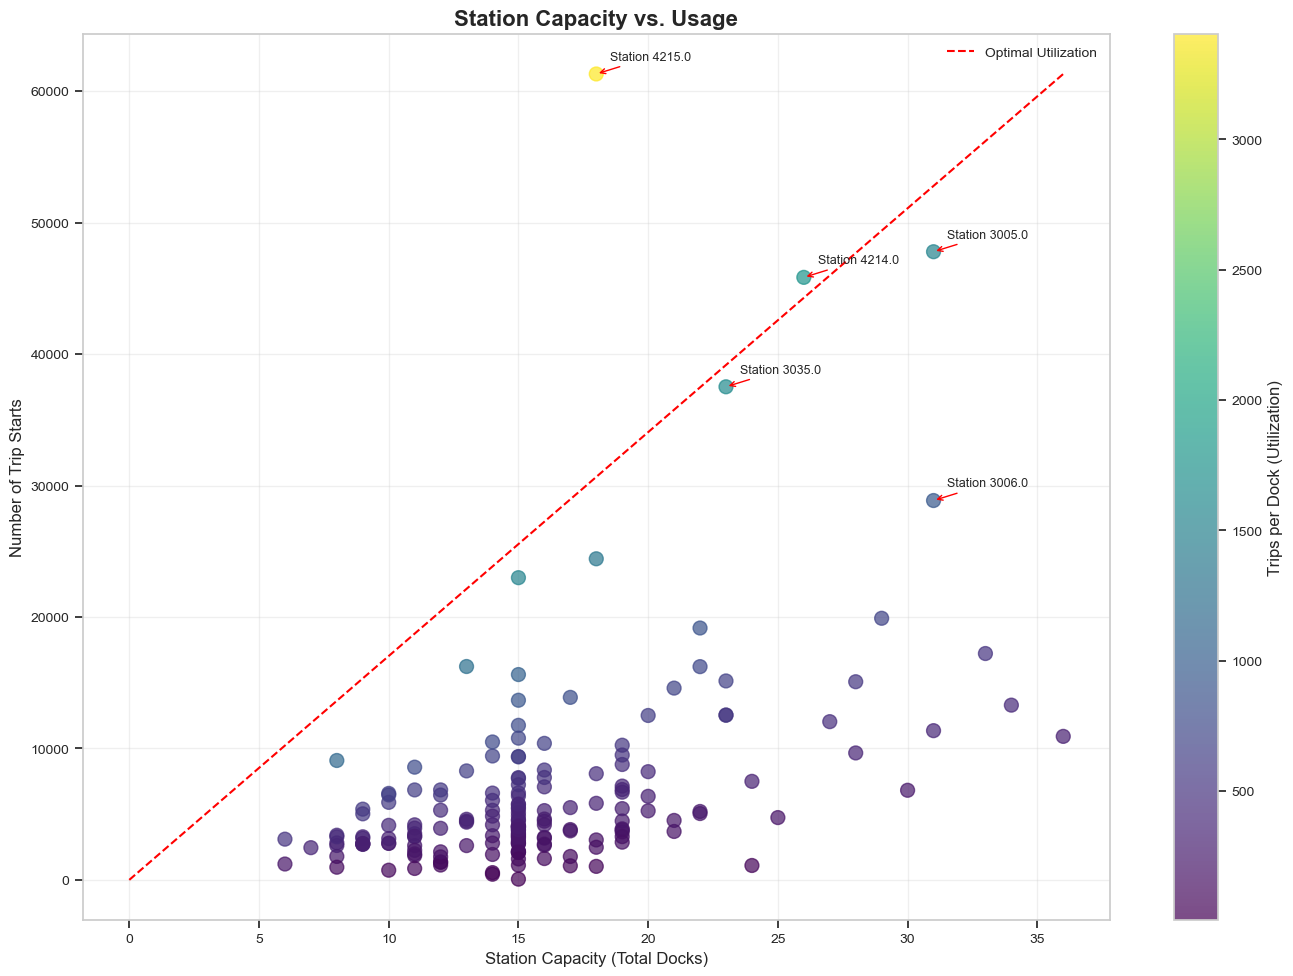

In [77]:
# Create a station capacity vs. usage visualization
station_usage = df.groupby('start_station').size().reset_index(name='trips')
station_capacity = stations[['station_id', 'total_docks']]
station_metrics = station_usage.merge(station_capacity, left_on='start_station', right_on='station_id', how='left')

plt.figure(figsize=(14, 10))

# Create a scatter plot with station capacity vs usage
scatter = plt.scatter(
    station_metrics['total_docks'],
    station_metrics['trips'],
    c=station_metrics['trips']/station_metrics['total_docks'],
    cmap='viridis',
    s=100,
    alpha=0.7
)

# Add a colorbar
cbar = plt.colorbar(scatter)
cbar.set_label('Trips per Dock (Utilization)')

# Add a line showing optimal utilization (can be adjusted)
max_ratio = station_metrics['trips'].max() / station_metrics['total_docks'].max()
x_vals = np.array([0, station_metrics['total_docks'].max()])
plt.plot(x_vals, x_vals * max_ratio, 'r--', label='Optimal Utilization')

# Annotate some notable stations
high_usage = station_metrics.nlargest(5, 'trips')
for _, station in high_usage.iterrows():
    plt.annotate(
        f"Station {station['start_station']}",
        (station['total_docks'], station['trips']),
        xytext=(10, 10),
        textcoords='offset points',
        fontsize=9,
        arrowprops=dict(arrowstyle='->', color='red')
    )

plt.title('Station Capacity vs. Usage', fontsize=16)
plt.xlabel('Station Capacity (Total Docks)')
plt.ylabel('Number of Trip Starts')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [59]:
revenue_by_plan = df_pricing.groupby('passholder_type').agg(
    total_trips=('trip_id', 'count'),
    total_revenue=('trip_cost', 'sum'),
    avg_revenue_per_trip=('trip_cost', 'mean')
).sort_values('total_revenue', ascending=False)
revenue_by_plan

,total_trips,total_revenue,avg_revenue_per_trip
passholder_type,,,
Walk-up,239488,9769553.50,40.79
Monthly Pass,960596,1168252.75,1.22
One Day Pass,88475,463699.25,5.24
Unknown,3643,106895.25,29.34


In [60]:
overage_stats = df_pricing[df_pricing['overage_minutes'] > 0].groupby('passholder_type').agg(
    rides_with_overage=('trip_id', 'count'),
    total_overage_revenue=('trip_cost', 'sum'),
    avg_overage_per_ride=('trip_cost', 'mean')
).sort_values('total_overage_revenue', ascending=False)
overage_stats

,rides_with_overage,total_overage_revenue,avg_overage_per_ride
passholder_type,,,
Walk-up,239488,9769553.50,40.79
Monthly Pass,62680,1168252.75,18.64
One Day Pass,21286,463699.25,21.78
Unknown,3643,106895.25,29.34


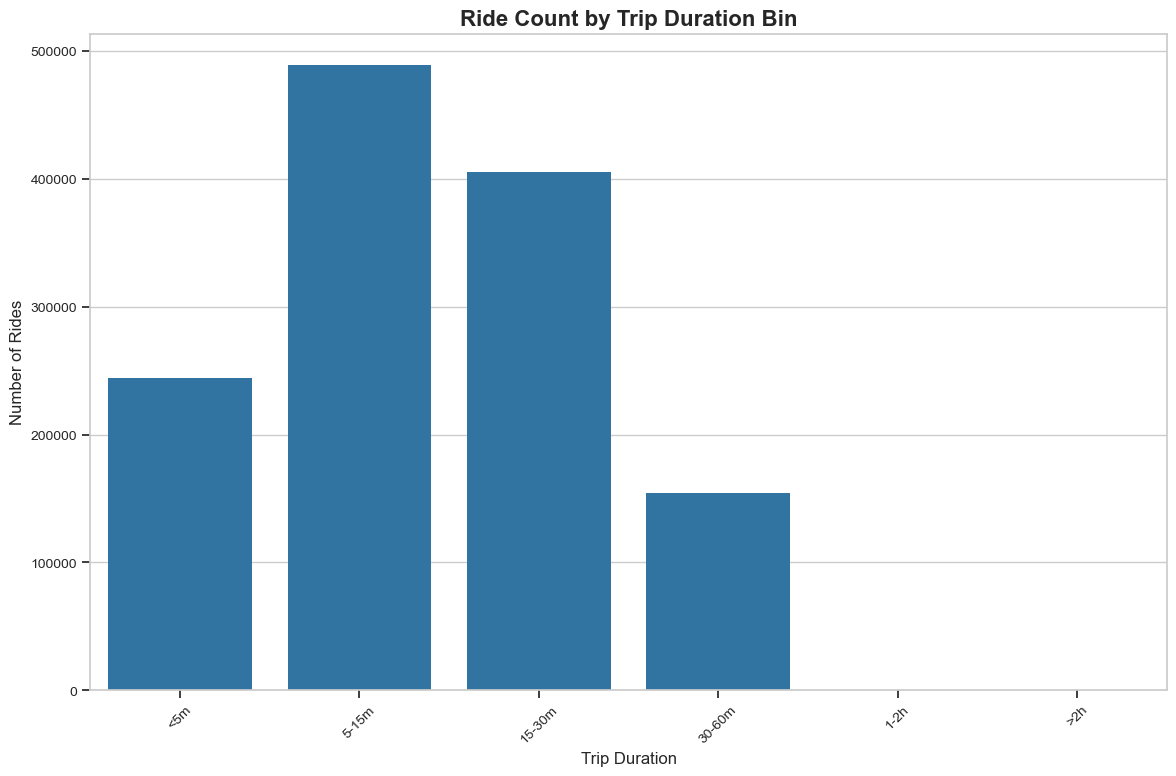

In [61]:
trip_duration_bins = df_pricing.groupby('duration_bin').agg(
    ride_count=('trip_id', 'count'),
    avg_trip_cost=('trip_cost', 'mean')
).reset_index()

sns.barplot(data=trip_duration_bins, x='duration_bin', y='ride_count')
plt.title('Ride Count by Trip Duration Bin')
plt.xlabel('Trip Duration')
plt.ylabel('Number of Rides')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

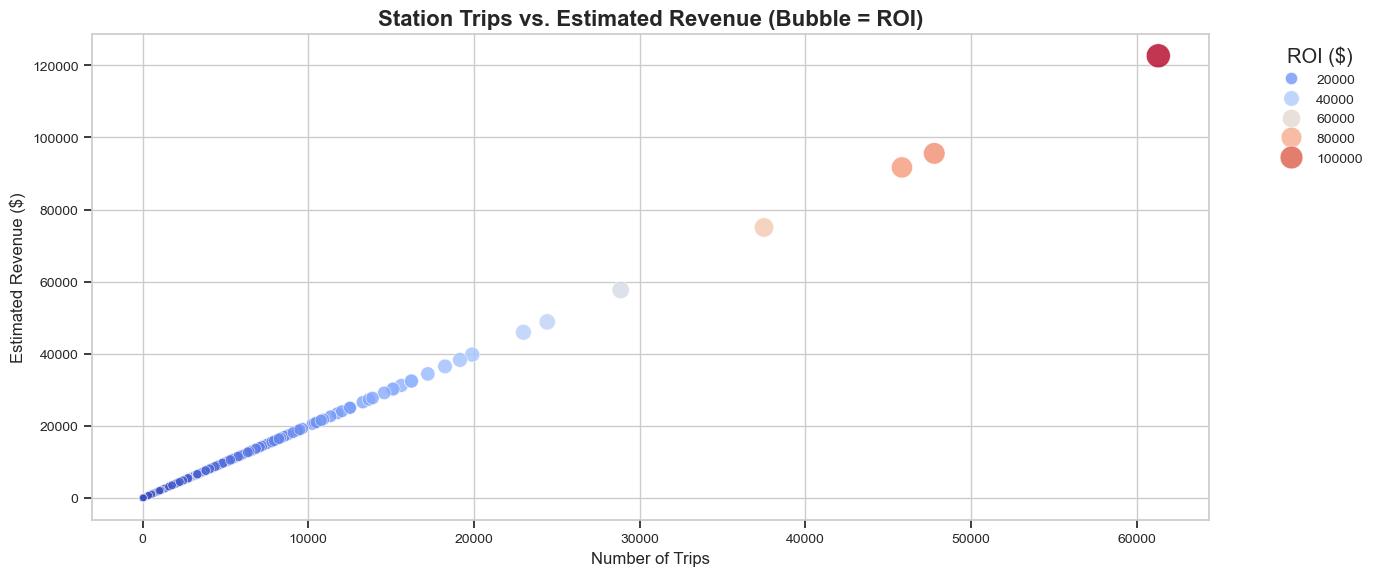

In [65]:
# Group metrics by start station
station_metrics = df.groupby('start_station').agg(
    trips=('trip_id', 'count'),
    start_lat=('start_lat', 'first'),
    start_lon=('start_lon', 'first')
).reset_index()

# Estimate revenue & ROI
station_metrics['revenue_est'] = station_metrics['trips'] * 2.0  # $2 per trip
station_metrics['rebalancing_cost'] = station_metrics['trips'] * 0.15  # $0.15 per trip rebalancing cost
station_metrics['roi'] = station_metrics['revenue_est'] - station_metrics['rebalancing_cost']

# Plot ROI as bubble chart
plt.figure(figsize=(14, 6))
sns.scatterplot(
    data=station_metrics,
    x='trips', y='revenue_est',
    size='roi', sizes=(30, 300),
    hue='roi', palette='coolwarm', alpha=0.8, legend='brief'
)
plt.title('Station Trips vs. Estimated Revenue (Bubble = ROI)')
plt.xlabel('Number of Trips')
plt.ylabel('Estimated Revenue ($)')
plt.legend(title='ROI ($)', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


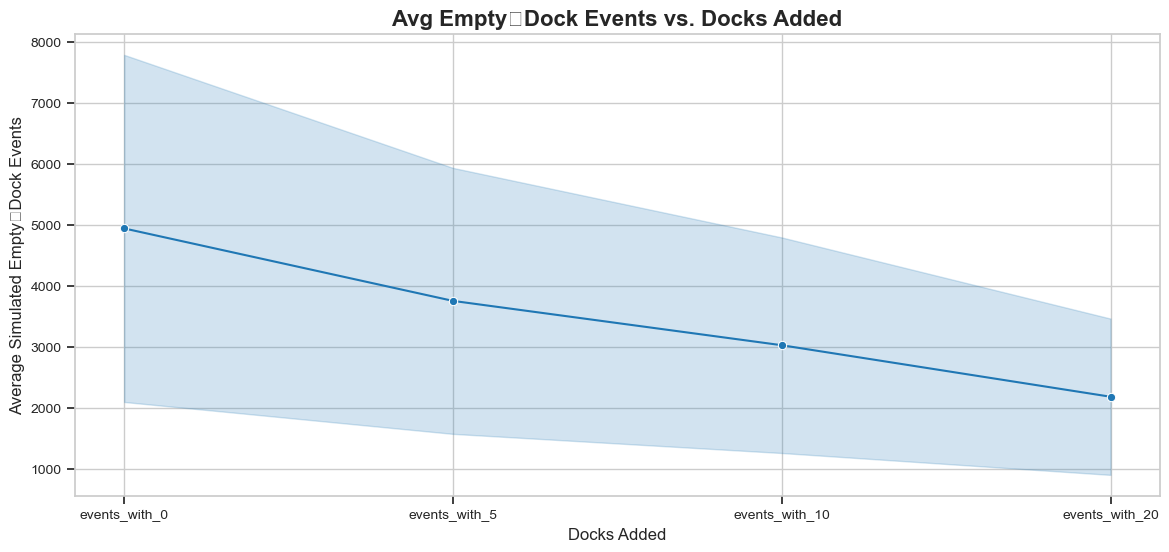

In [66]:
# 3) Impact on System Balance
# — line plot: simulate how many empty‐dock events remain if we add X docks
# Count empty‐dock events (when a trip ends and docks_available==0)
empty = df[df['docks_available']==0].groupby('start_station').size().reset_index(name='events')
cap   = stations[['station_id','total_docks']]
sim   = empty.merge(cap, left_on='start_station', right_on='station_id', how='left')

# Simulate adding docks
for X in [0,5,10,20]:
    sim[f'events_with_{X}'] = sim['events'] * (sim['total_docks'] / (sim['total_docks'] + X))
sim_long = sim.melt(
    id_vars=['start_station'],
    value_vars=[f'events_with_{X}' for X in [0,5,10,20]],
    var_name='docks_added',
    value_name='sim_events'
)

plt.figure(figsize=(14,6))
sns.lineplot(
    data=sim_long,
    x='docks_added', y='sim_events',
    estimator='mean', marker='o', palette='magma'
)
plt.title('Avg Empty‑Dock Events vs. Docks Added')
plt.xlabel('Docks Added')
plt.ylabel('Average Simulated Empty‑Dock Events')
plt.show()

In [67]:
# # 4) Partnership & Bulk‑Sales Opportunities
# # — bar chart: cities (or ZIPs) with highest trips per station
# trips_city    = df.groupby('station_city').size().reset_index(name='trips')
# stations_city = stations.groupby('station_city').size().reset_index(name='station_count')
# city_metrics  = trips_city.merge(stations_city, on='station_city', how='left')
# city_metrics['trips_per_station'] = city_metrics['trips'] / city_metrics['station_count']

# top_cities = city_metrics.nlargest(10, 'trips_per_station')

# plt.figure(figsize=(14,6))
# sns.barplot(
#     data=top_cities,
#     x='station_city', y='trips_per_station',
#     palette='Spectral'
# )
# plt.title('Top 10 Cities by Trips per Station')
# plt.xlabel('City')
# plt.ylabel('Trips per Station')
# plt.xticks(rotation=45)
# plt.show()

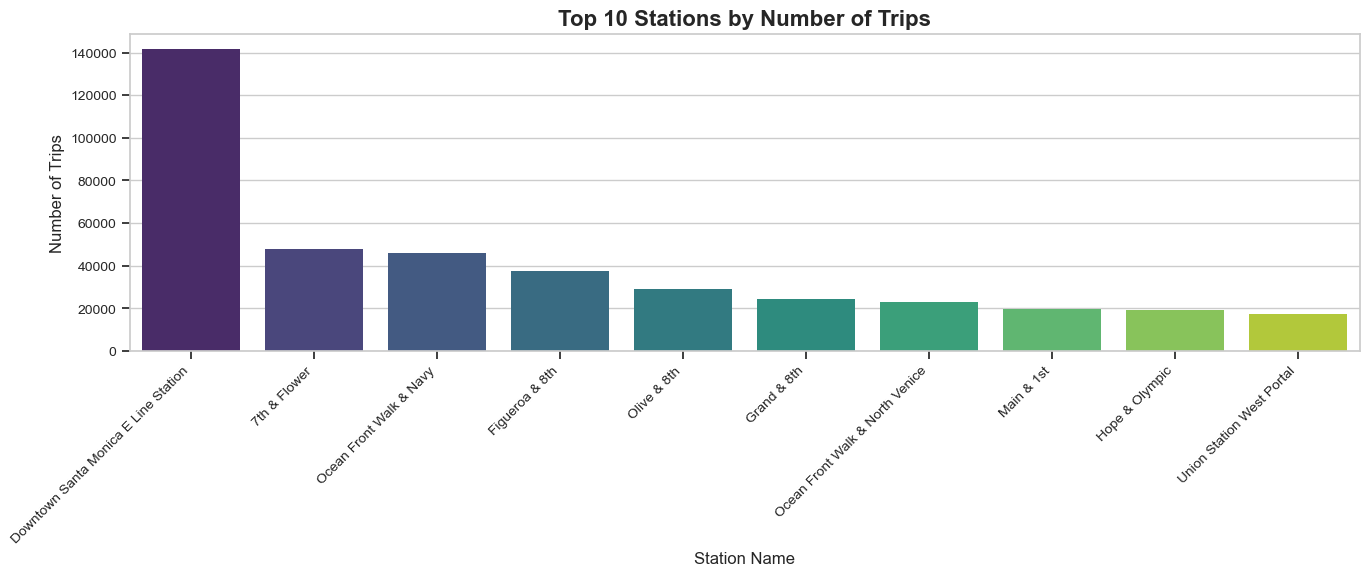

In [68]:
# 4) Partnership & Bulk-Sales Opportunities
# — bar chart: cities (or stations) with highest trips per station

# Group by station_name if city information is missing
trips_station = df.groupby('station_name').size().reset_index(name='trips')

# Plot bar chart for trips per station
plt.figure(figsize=(14, 6))
sns.barplot(
    data=trips_station.sort_values('trips', ascending=False).head(10),
    x='station_name', y='trips', palette='viridis'
)
plt.title('Top 10 Stations by Number of Trips')
plt.xlabel('Station Name')
plt.ylabel('Number of Trips')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## **Modeling**